# 30100 Individual Project
## Protest Escalation into Violence (ACLED + V-Dem + VIIRS NTL)

**Research question:** Why do some protests escalate into violence while others remain peaceful?

**Task:** binary classification where `y_binary = 1` for **Violent demonstration** and `0` for **Peaceful protest**.

**Scope:**
- Countries: Argentina, Brazil, Chile, Colombia, Mexico, Peru
- Time window: **2021–2024** (VIIRS annual NTL alignment)
- External features:
  - V-Dem (country-year): `v2x_libdem`, `v2x_civlib`
  - Night-time lights (VIIRS NTL): mean / p90 / std within 5km buffer around event coordinates (exported from Google Earth Engine)

**Evaluation design:**  
Primary evaluation uses a **temporal split** to mimic forecasting and reduce leakage:
- Train: 2021–2022
- Validation: 2023
- Test: 2024

A random seed (`random_state`) is used for reproducibility.


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Load data

This notebook is built upon:
- `acled_data.csv` (filtered ACLED extract)
- `vdem.csv` (V-Dem extract)
- NTL exports from GEE already saved locally:
  - `events_2021_with_ntl_2020_5km.csv`
  - `events_2022_with_ntl_2021_5km.csv`
  - `events_2023_with_ntl_2022_5km.csv`
  - `events_2024_with_ntl_2023_5km.csv`

### Data Source (NTL)
The four CSV files above were generated using Google Earth Engine (GEE). 
They contain night-time lights (NTL) summary statistics (e.g., mean / p90 / std within a 5km buffer) matched to ACLED events by event ID and year.

In [2]:
acled = pd.read_csv("acled_data.csv")
vdem  = pd.read_csv("vdem.csv")

print("ACLED shape:", acled.shape)
print("V-Dem shape:", vdem.shape)
acled.head()

ACLED shape: (156153, 31)
V-Dem shape: (27913, 1818)


,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,VEN6368,2018-01-01,2018,1,Demonstrations,Protests,Peaceful protest,Protesters (Venezuela),NaN,Protesters,...,Maturin,9.7457,-63.1832,1,Caraota Digital,National,"On 1 January 2018, residents from the neighbor...",0,NaN,1607554919
1,BRA24093,2018-01-01,2018,2,Demonstrations,Protests,Peaceful protest,Protesters (Brazil),NaN,Protesters,...,Teresina,-5.0892,-42.8019,1,G1,National,"At the beginning of January 2018, in Teresina,...",0,crowd size=nearly 60,1607554969
2,BRA35626,2018-01-01,2018,1,Demonstrations,Protests,Peaceful protest,Protesters (Brazil),NaN,Protesters,...,Cuiaba,-15.5961,-56.0967,1,G1,National,"On 1 January 2018, local residents protested i...",0,crowd size=no report,1607555018
3,BRA20331,2018-01-01,2018,1,Political violence,Riots,Mob violence,Rioters (Brazil),Vigilante Group (Brazil),Rioters,...,Rio de Janeiro - North Zone,-22.8569,-43.3008,1,G1,National,"On 1 January 2018, in the northern zone of Rio...",0,crowd size=no report,1611096807
4,VEN8468,2018-01-01,2018,2,Political violence; Demonstrations,Protests,Excessive force against protesters,Protesters (Venezuela),Women (Venezuela),Protesters,...,Caracas - Libertador,10.5127,-66.9129,1,Venezuelanalysis.com,International,"Around 1 January 2018 (as reported), in Caraca...",1,crowd size=no report; women targeted: protesters,1675724415


- **ACLED events:** 156,153 rows × 31 columns (event-level observations).
- **V-Dem:** 27,913 rows × 1,818 columns (country-year panel with many indicators; we will subset to a small set of relevant features).

## 2) Define label (`y`) and restrict to comparable protest events

We restrict to **Demonstrations** and keep only two `sub_event_type` values:
- **Peaceful protest** → `y_binary = 0`
- **Violent demonstration** → `y_binary = 1`

This avoids mixing in other ACLED categories where “violence” is defined differently (e.g., armed clashes).

In [3]:
SUB = "sub_event_type"
DIS = "disorder_type"

df = acled.loc[
    (acled[DIS] == "Demonstrations") &
    (acled[SUB].isin(["Peaceful protest", "Violent demonstration"]))
].copy()

df["y_binary"] = (df[SUB] == "Violent demonstration").astype(int)

# Simple text heuristic (optional)
df["is_intervention"] = (
    df["notes"]
    .astype(str)
    .str.contains("intervention", case=False, na=False)
    .astype(int)
)

df[[DIS, SUB, "y_binary", "is_intervention"]].head()

,disorder_type,sub_event_type,y_binary,is_intervention
0,Demonstrations,Peaceful protest,0,0
1,Demonstrations,Peaceful protest,0,0
2,Demonstrations,Peaceful protest,0,0
6,Demonstrations,Peaceful protest,0,0
7,Demonstrations,Peaceful protest,0,0


## 3) EDA

### 3.1 What does the data look like?

In [4]:
key_cols = [c for c in ["event_id_cnty", "event_date", "year", "country", "admin1", "location", SUB, "y_binary"] if c in df.columns]
df[key_cols].sample(10, random_state=RANDOM_STATE)

,event_id_cnty,event_date,year,country,admin1,location,sub_event_type,y_binary
153660,ARG15929,2024-11-06,2024,Argentina,Tucuman,San Miguel de Tucuman,Peaceful protest,0
64529,ARG6764,2021-02-24,2021,Argentina,Buenos Aires,La Plata,Peaceful protest,0
60174,ARG4009,2020-12-04,2020,Argentina,Buenos Aires,La Plata,Peaceful protest,0
114485,BRA63188,2023-01-23,2023,Brazil,Sao Paulo,Cubatao,Peaceful protest,0
144998,ARG15224,2024-06-05,2024,Argentina,Chubut,Comodoro Rivadavia,Peaceful protest,0
140100,MEX84815,2024-03-08,2024,Mexico,Guanajuato,Celaya,Peaceful protest,0
89466,MEX56759,2022-02-23,2022,Mexico,Michoacan de Ocampo,Morelia,Peaceful protest,0
7961,BRA30513,2018-05-23,2018,Brazil,Sao Paulo,Ribeirao Preto,Peaceful protest,0
95491,BRA55243,2022-05-10,2022,Brazil,Minas Gerais,Sao Joao del Rei,Peaceful protest,0
142612,MEX86748,2024-04-25,2024,Mexico,Veracruz de Ignacio de la Llave,Xalapa-Enriquez,Peaceful protest,0


What you see above is a randomly sample of 10 rows from the main event table to illustrate the raw data structure and key fields (event ID, date/year, country/admin1, and location) that will be used for filtering and merges.

In [5]:
# target column
y_col = "y_binary"

display_cols = [
    "event_id_cnty", "event_date", "country", "admin1", "location",
    "sub_event_type", "fatalities", "notes"
]

display_cols = [c for c in display_cols if c in df.columns]

seed = 42

violent_ex = df.loc[df[y_col] == 1, display_cols].sample(
    n=min(5, (df[y_col] == 1).sum()), random_state=seed
).assign(_class="violent (y_binary=1)")

peaceful_ex = df.loc[df[y_col] == 0, display_cols].sample(
    n=min(5, (df[y_col] == 0).sum()), random_state=seed
).assign(_class="peaceful (y_binary=0)")

examples = pd.concat([violent_ex, peaceful_ex], axis=0).reset_index(drop=True)

examples = examples[["_class"] + display_cols]

examples

,_class,event_id_cnty,event_date,country,admin1,location,sub_event_type,fatalities,notes
0,violent (y_binary=1),MEX41103,2021-01-22,Mexico,Jalisco,Acatlan de Juarez,Violent demonstration,0,"On 22 January 2021, in Acatlan de Juarez, Jali..."
1,violent (y_binary=1),COL9319,2021-11-25,Colombia,Bolivar,Cartagena,Violent demonstration,0,"On 25 November 2021, in Cartagena (Bolivar), d..."
2,violent (y_binary=1),MEX28033,2018-02-11,Mexico,Ciudad de Mexico,Ciudad de Mexico - Venustiano Carranza,Violent demonstration,0,"On 11 February 2018, in Venustiano Carranza of..."
3,violent (y_binary=1),CHI12357,2024-09-11,Chile,Metropolitana,Santiago - Los Cerrillos,Violent demonstration,0,"On 11 September 2024, in Santiago - Los Cerril..."
4,violent (y_binary=1),BRA22519,2018-09-30,Brazil,Piaui,Monsenhor Hipolito,Violent demonstration,0,"On 30 September 2018, in Monsenhor Hipolito, P..."
5,peaceful (y_binary=0),MEX43997,2021-03-30,Mexico,Chiapas,Comitan de Dominguez,Peaceful protest,0,"On 30 March 2021, in Comitan de Dominguez muni..."
6,peaceful (y_binary=0),MEX51376,2021-10-06,Mexico,Guerrero,Acapulco de Juarez,Peaceful protest,0,"On 6 October 2021, in Acapulco de Juarez, Guer..."
7,peaceful (y_binary=0),MEX19968,2020-06-25,Mexico,Ciudad de Mexico,Ciudad de Mexico - Cuauhtemoc,Peaceful protest,0,"On 25 June 2020, in Cuauhtemoc, Ciudad de Mexi..."
8,peaceful (y_binary=0),CHI2686,2019-12-23,Chile,Maule,San Clemente,Peaceful protest,0,"On 23 December 2019, in the route that connect..."
9,peaceful (y_binary=0),MEX45146,2021-04-26,Mexico,Tlaxcala,Tlaxcala de Xicohtencatl,Peaceful protest,0,"On 26 April 2021, in Tlaxcala de Xicohtencatl,..."


What you see above are randomly sampled examples (5+5) from both peaceful and violent classes to verify the label definition: `y_binary=1` corresponds to *Violent demonstration* and `y_binary=0` corresponds to *Peaceful protest*. 

### 3.2 Data size & target distribution

In [6]:
print("Rows:", len(df), "| Columns:", df.shape[1])
print("Violent share (overall):", df["y_binary"].mean().round(4))
df["y_binary"].value_counts(dropna=False)

Rows: 143737 | Columns: 33
Violent share (overall): 0.0849


y_binary
0    131529
1     12208
Name: count, dtype: int64

As we can see here, because the positive class "1" (violent) is typically a minority (only around 8%), we report class shares and will set metrics accordingly (F1, PR-AUC, ROC-AUC) later on.

## 4) Merge external features (V-Dem + VIIRS NTL)

**V-Dem** is country-year; **NTL** is event-level (from GEE) but with year offset (NTL year = event year - 1 in our exports).  
We align carefully to avoid leakage from *future* information.

In [7]:
# --- V-Dem merge keys (fixed columns) ---
vdem_small = vdem[["country_name", "year", "v2x_libdem", "v2x_civlib"]].copy()

# normalize key names
df_m = df.copy()
df_m["country_key"] = df_m["country"]
df_m["year_key"] = df_m["year"]

vdem_small = vdem_small.rename(columns={"country_name": "country_key", "year": "year_key"})

df_m = df_m.merge(vdem_small, on=["country_key", "year_key"], how="left")

print("After V-Dem merge:", df_m.shape)
print("V-Dem missing rate:", df_m[["v2x_libdem", "v2x_civlib"]].isna().mean().round(4).to_dict())

After V-Dem merge: (143737, 37)
V-Dem missing rate: {'v2x_libdem': 0.0016, 'v2x_civlib': 0.0016}


**Merge check (V-Dem):**  
After merging V-Dem country–year covariates into the event-level dataset, the dataframe has **143,737 rows × 37 columns** (row count unchanged, indicating a successful left join without duplicating events). Missingness for the two retained V-Dem features is very low (**~0.16%** for both `v2x_libdem` and `v2x_civlib`), which will be handled later via median imputation in the preprocessing pipeline.

### 4.1 Merge NTL exports

### Merge night-time lights (NTL) covariates (exported from Google Earth Engine)

The following code loads four year-specific NTL CSV exports and merges them into the ACLED event-level dataset using a stable event identifier (`event_id_cnty`) and the event year (`year_key`).  
Note: the file naming indicates that year *t* events are matched with NTL imagery from year *t−1* (e.g., 2024 events use 2023 NTL), which helps reduce simultaneity.  
After the merge, I report the new dataframe shape and the missing rate of the NTL features.

In [8]:
ntl_files = {
    2021: "events_2021_with_ntl_2020_5km.csv",
    2022: "events_2022_with_ntl_2021_5km.csv",
    2023: "events_2023_with_ntl_2022_5km.csv",
    2024: "events_2024_with_ntl_2023_5km.csv",
}


event_id_col = "event_id_cnty"
if event_id_col not in df_m.columns:
    raise KeyError(f"df_m missing '{event_id_col}'. Available columns (first 30): {list(df_m.columns)[:30]}")

ntl_dfs = []
for yr, fp in ntl_files.items():
    tmp = pd.read_csv(fp)
    tmp["year_key"] = yr

    if event_id_col not in tmp.columns:
        raise KeyError(
            f"NTL file {fp} missing '{event_id_col}'. "
            f"Available columns (first 30): {list(tmp.columns)[:30]}"
        )

    ntl_cols = [c for c in tmp.columns if c.startswith("ntl_") or ("ntl_" in c)]
    if len(ntl_cols) == 0:
        raise KeyError(
            f"NTL file {fp} has no NTL columns (expected columns containing 'ntl_'). "
            f"Available columns (first 30): {list(tmp.columns)[:30]}"
        )

    ntl_dfs.append(tmp[[event_id_col, "year_key"] + ntl_cols])

ntl_all = pd.concat(ntl_dfs, ignore_index=True)

# IMPORTANT: make sure df_m has year_key already; if not, create it from df_m['year']
if "year_key" not in df_m.columns:
    df_m["year_key"] = df_m["year"]

df_m = df_m.merge(
    ntl_all,
    on=[event_id_col, "year_key"],
    how="left"
)

print("After NTL merge:", df_m.shape)
ntl_cols = [c for c in df_m.columns if c.startswith("ntl_") or ("ntl_" in c)]
print("NTL missing rate:", df_m[ntl_cols].isna().mean().round(4).to_dict())

After NTL merge: (143737, 41)
NTL missing rate: {'ntl_mean_5km': 0.5352, 'ntl_p90_5km': 0.5352, 'ntl_std_5km': 0.5352, 'ntl_year': 0.5352}


**Merge check (NTL, preliminary).**  
After merging the GEE-derived night-time lights (NTL) exports, the dataframe has **143,737 rows × 41 columns** (row count unchanged, consistent with a left join that does not duplicate events). The overall missing rate for NTL features is **~53.5%**, meaning that roughly half of event records do not have a matched NTL row in the exported tables.

This high missingness is expected at this stage because the event dataset currently spans **2018–2024**, while the available NTL exports are only provided for **event years 2021–2024** (with year *t* events matched to year *t−1* imagery). Events outside the export years (e.g., 2018–2020) therefore have missing NTL by construction. In the next step, I restrict the analysis sample to the six target countries and the in-scope years (2021–2024), and I will re-report NTL missingness for the final modeling dataset.

## 6) Restrict to 6 countries and 2021–2024

- Focus on 6 countries (your proposal set)
- Focus on 2021–2024 so that NTL coverage is strong and the pipeline is tractable.

In [9]:
# ---- Scope restriction (6 countries + 2021-2024) ----
six_list = ["Chile","Colombia","Brazil","Mexico","Peru","Argentina"]

df_m = df_m[df_m["country"].isin(six_list)].copy()
df_m = df_m[df_m["year"].between(2021, 2024)].copy()

print("Rows after filters:", len(df_m))

print("\nYears:")
print(df_m["year"].value_counts().sort_index())

print("\nCountries:")
print(df_m["country"].value_counts().reindex(six_list))

# ---- NTL merge quality check ----
ntl_cols = ["ntl_mean_5km", "ntl_p90_5km", "ntl_std_5km"]
missing_cols = [c for c in ntl_cols if c not in df_m.columns]
if missing_cols:
    print("\n[Warning] Missing NTL columns in df_m:", missing_cols)
else:
    print("\nNTL missing rate after filter:")
    print(df_m[ntl_cols].isna().mean().round(4))

Rows after filters: 67087

Years:
year
2021    18661
2022    18084
2023    16994
2024    13348
Name: count, dtype: int64

Countries:
country
Chile         5472
Colombia      8408
Brazil       11623
Mexico       24534
Peru          7665
Argentina     9385
Name: count, dtype: int64

NTL missing rate after filter:
ntl_mean_5km    0.004
ntl_p90_5km     0.004
ntl_std_5km     0.004
dtype: float64


**Final analysis sample (after scope filters).**  
After restricting the dataset to the six target countries (Argentina, Brazil, Chile, Colombia, Mexico, Peru) and the in-scope years (2021–2024), the modeling sample contains **67,087 events**. The table above shows that observations are reasonably distributed across years (2021–2024) and across the six countries (with Mexico contributing the largest share of events).  

Importantly, once the scope is restricted to years covered by the GEE exports, NTL feature missingness drops to **~0.4%**, indicating that the earlier high missing rate was primarily driven by out-of-scope years (e.g., 2018–2020) rather than a systematic merge failure.

## Visualizations

Violent share (overall): 0.0812


,count
y_binary,
0,61638
1,5449


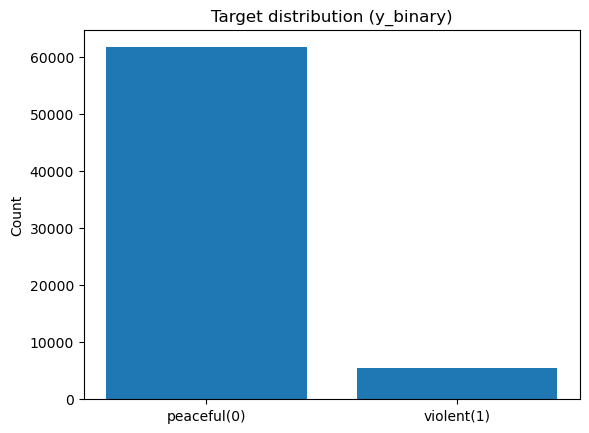

In [10]:
counts = df_m[y_col].value_counts().sort_index()
violent_share = float(df_m[y_col].mean())

print("Violent share (overall):", round(violent_share, 4))
display(counts.to_frame("count"))

plt.figure()
plt.bar(["peaceful(0)", "violent(1)"], counts.values)
plt.title("Target distribution (y_binary)")
plt.ylabel("Count")
plt.show()

**Target distribution (y_binary).** The dataset is **imbalanced**: most events are labeled **peaceful (0)** and only a small fraction are **violent (1)** (≈8%). Because of this imbalance, **accuracy alone is not informative**—later model evaluation will emphasize **Precision/Recall/F1** and **PR-AUC**, and we also use **class weighting** to mitigate the imbalance.

,year,n,violent_rate
0,2021,18661,0.088848
1,2022,18084,0.091241
2,2023,16994,0.071496
3,2024,13348,0.069374


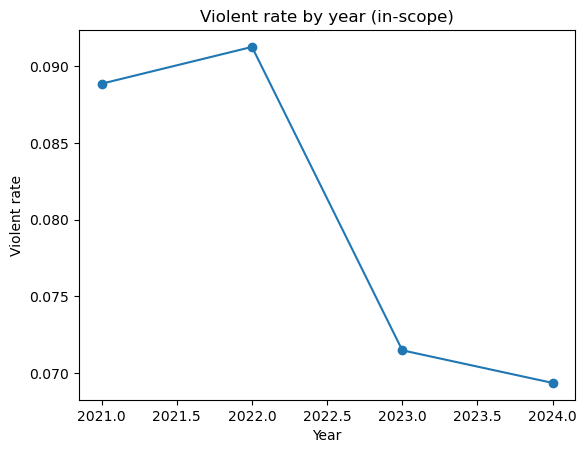

In [11]:
by_year = (df_m.groupby("year")[y_col]
             .agg(n="size", violent_rate="mean")
             .reset_index())
display(by_year)

plt.figure()
plt.plot(by_year["year"], by_year["violent_rate"], marker="o")
plt.title("Violent rate by year (in-scope)")
plt.xlabel("Year"); plt.ylabel("Violent rate")
plt.show()

**Violent rate by year (in-scope).** The proportion of violent demonstrations varies across years (higher in 2021–2022 and lower in 2023–2024). This time variation motivates a **time-based split** (train on earlier years, validate/test on later years) to better reflect a realistic “predict future escalation” setting and to reduce temporal leakage.

,n,violent_rate
country,,
Mexico,24534,0.041942
Brazil,11623,0.115805
Argentina,9385,0.051998
Colombia,8408,0.115485
Peru,7665,0.086628
Chile,5472,0.173794


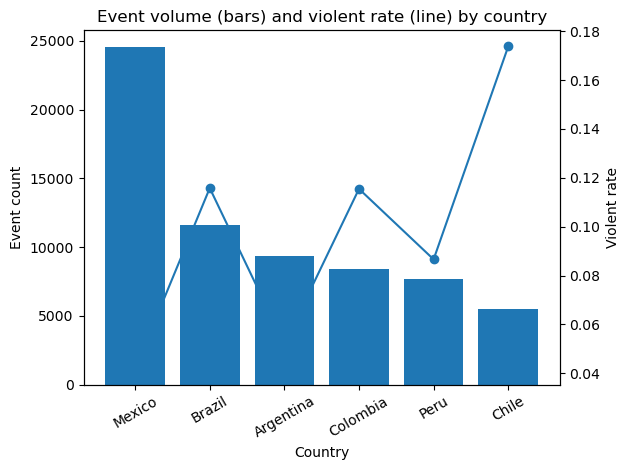

In [12]:
by_ctry = (df_m.groupby("country")[y_col]
             .agg(n="size", violent_rate="mean")
             .sort_values("n", ascending=False))

display(by_ctry)

fig, ax1 = plt.subplots()
ax1.bar(by_ctry.index, by_ctry["n"])
ax1.set_title("Event volume (bars) and violent rate (line) by country")
ax1.set_xlabel("Country")
ax1.set_ylabel("Event count")
ax1.tick_params(axis='x', rotation=30)

ax2 = ax1.twinx()
ax2.plot(by_ctry.index, by_ctry["violent_rate"], marker="o")
ax2.set_ylabel("Violent rate")

plt.tight_layout()
plt.show()

**Event volume and violent rate by country (in-scope).** Event counts vary substantially across the six countries (bars), and the **violent rate also differs by country** (line). This indicates meaningful **cross-country heterogeneity** in both sample size and baseline risk, which motivates (i) keeping **country** as a key grouping/stratification variable in analysis and (ii) using evaluation metrics beyond accuracy to avoid results being dominated by the highest-volume countries.

,missing_rate
ntl_mean_5km,0.00404
ntl_p90_5km,0.00404
ntl_std_5km,0.00404
v2x_libdem,0.00000
v2x_civlib,0.00000


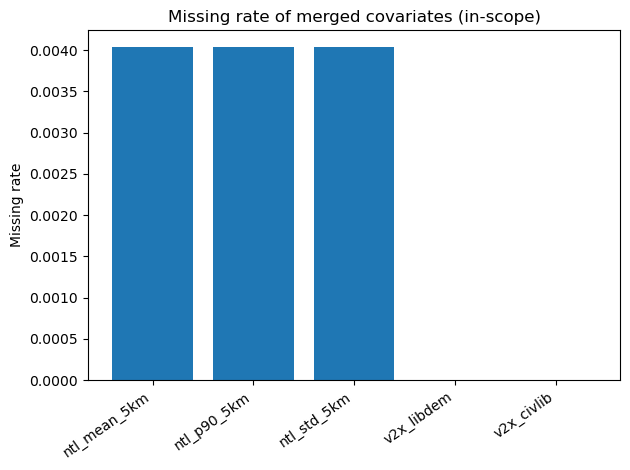

In [13]:
check_cols = [c for c in [
    "v2x_libdem", "v2x_civlib",
    "ntl_mean_5km", "ntl_p90_5km", "ntl_std_5km"
] if c in df_m.columns]

miss = df_m[check_cols].isna().mean().sort_values(ascending=False)
display(miss.to_frame("missing_rate"))

plt.figure()
plt.bar(miss.index, miss.values)
plt.title("Missing rate of merged covariates (in-scope)")
plt.ylabel("Missing rate")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

**Missing rate of merged covariates (in-scope).** After restricting to the six countries and 2021–2024, the merged covariates have **very low missingness** (≈0.4% for the NTL features; V-Dem indicators are effectively complete). This suggests the merge keys are working as intended, and remaining missing values can be handled with **simple imputation** (median for numeric features) without materially reducing sample size.

## 5) Feature engineering (history / diffusion) with leakage control

**Why these features？** Our goal is to predict whether a demonstration escalates into a **violent demonstration**. Theory and prior empirical work suggest escalation risk is not purely event-specific: it can depend on the **recent local conflict/protest environment** (e.g., tension, policing, mobilization capacity), and on **broader country-level conditions** (institutions, civic freedoms, economic/activity context). To operationalize these ideas, we construct:

- **History / persistence (30D, 90D):** recent counts of demonstrations and the recent **share that were violent** at both the *city* and *country* level. These capture short-run persistence and “baseline risk” in the immediate environment.
- **Diffusion / intensity proxies:** same-day activity measures (e.g., multiple events in the same place/day) as a lightweight proxy for heightened mobilization or coordinated waves of protest.

**Leakage control (why `shift(1)`).** Because the target label is defined for the current event, we must ensure features do not accidentally use information from the **same event/day** or the future. We therefore compute rolling historical features on **daily aggregates** and apply `shift(1)` so that, for each event, the history variables only summarize **strictly prior days**. This setup matches the predictive setting “using information available up to yesterday to predict whether today’s demonstration turns violent,” and avoids inflating performance via temporal leakage.

*Note:* Same-day intensity variables are treated as a separate, explicitly contemporaneous signal; my interpretation of the modeling goal for this project is strictly “forecast before the day begins,” therefore I drop the same-day noice.

In [14]:
import numpy as np
import pandas as pd
from IPython.display import display

# ============================================================
# Feature engineering
# - Define label from sub_event_type
# - Create keys + time features
# - Rolling history computed on DAILY aggregates with shift(1 day)
#   (same-day NOT counted as past)
# - IMPORTANT: rolling is computed using df_hist (longer history),
#   then merged into df_m (6 countries, 2021-2024)
# ============================================================

# --- 0) choose event table for rolling history ---
# df_m: already filtered to 6 countries + 2021-2024
# df_hist: longer history (recommended). If not available, fallback to df_m.

try:
    df_hist
except NameError:
    df_hist = df_m.copy()
    print("[Note] df_hist not found; using df_m (2021-2024 only) for rolling history. "
          "This may weaken early-2021 history features.")

# --- 1) ensure datetime ---
for _df in [df_m, df_hist]:
    _df["event_date"] = pd.to_datetime(_df["event_date"], errors="coerce")
    if _df["event_date"].isna().any():
        bad_n = int(_df["event_date"].isna().sum())
        raise ValueError(f"event_date has {bad_n} invalid values after to_datetime().")

# --- 2) define research sample + label on BOTH df_m and df_hist ---
DIS = "disorder_type"
SUB = "sub_event_type"

need_cols = [DIS, SUB, "country", "admin1", "location"]
for nm, _df in [("df_m", df_m), ("df_hist", df_hist)]:
    missing = [c for c in need_cols if c not in _df.columns]
    if missing:
        raise KeyError(f"{nm} missing required columns: {missing}")

def restrict_to_demo_and_label(_df):
    out = _df.loc[
        (out := _df)[DIS].eq("Demonstrations") &
        out[SUB].isin(["Peaceful protest", "Violent demonstration"])
    ].copy()
    out["violent"] = out[SUB].eq("Violent demonstration").astype(int)
    return out

df_m = restrict_to_demo_and_label(df_m)
df_hist = restrict_to_demo_and_label(df_hist)

print("Label distribution (modeling df_m):")
display(df_m["violent"].value_counts().to_frame("count"))
print("violent rate:", round(df_m["violent"].mean(), 4))

# --- 3) keys + time features (apply to BOTH for consistent merge) ---
def add_keys_time(_df):
    out = _df.copy()
    out["country_s"] = out["country"].astype(str).fillna("NA")
    out["admin1_s"]  = out["admin1"].astype(str).fillna("NA")
    out["loc_s"]     = out["location"].astype(str).fillna("NA")

    out["city_key"]   = out["country_s"] + "||" + out["admin1_s"] + "||" + out["loc_s"]
    out["admin1_key"] = out["country_s"] + "||" + out["admin1_s"]

    dt = out["event_date"]
    out["month"] = dt.dt.month
    out["dow"] = dt.dt.dayofweek
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    out["weekofyear"] = dt.dt.isocalendar().week.astype(int)

    # daily timestamp for rolling
    out["date_only"] = pd.to_datetime(out["event_date"].dt.date)
    return out

df_m = add_keys_time(df_m)
df_hist = add_keys_time(df_hist)

# --- 4) daily rolling features (same-day NOT counted as past) ---
def add_daily_rolling_features(df_event, group_col, date_col="date_only",
                               y_col="violent", windows=("30D", "90D"), prefix="ctry"):
    daily = (df_event.groupby([group_col, date_col], as_index=False)
                    .agg(day_event_count=(y_col, "size"),
                         day_violent_count=(y_col, "sum")))
    daily = daily.sort_values([group_col, date_col]).reset_index(drop=True)
    g = daily.groupby(group_col, group_keys=False)

    for w in windows:
        cnt = (g.rolling(w, on=date_col)["day_event_count"]
                .sum().shift(1).reset_index(level=0, drop=True))
        vcnt = (g.rolling(w, on=date_col)["day_violent_count"]
                 .sum().shift(1).reset_index(level=0, drop=True))

        daily[f"{prefix}_past_{w}_count"] = cnt.to_numpy()
        daily[f"{prefix}_past_{w}_violent_count"] = vcnt.to_numpy()

        denom = daily[f"{prefix}_past_{w}_count"].replace(0, np.nan)
        daily[f"{prefix}_past_{w}_violent_share"] = daily[f"{prefix}_past_{w}_violent_count"] / denom

    feat_cols = [c for c in daily.columns if c.startswith(f"{prefix}_past_")]
    daily[feat_cols] = daily[feat_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    return daily[[group_col, date_col] + feat_cols]

# compute history on df_hist (longer history)
ctry_daily = add_daily_rolling_features(df_hist, group_col="country", prefix="ctry")
city_daily = add_daily_rolling_features(df_hist, group_col="city_key", prefix="city")

# --- 5) merge into df_m (modeling set) ---
df_m = df_m.merge(ctry_daily, on=["country", "date_only"], how="left")
df_m = df_m.merge(city_daily, on=["city_key", "date_only"], how="left")

past_cols = [c for c in df_m.columns if "_past_" in c]
df_m[past_cols] = df_m[past_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

print("Total columns now:", df_m.shape[1])

cols_to_show = [
    "country", "event_date", "violent",
    "city_past_30D_count", "city_past_30D_violent_share",
    "ctry_past_30D_count", "ctry_past_30D_violent_share",
]
display(df_m[cols_to_show].head(12))

[Note] df_hist not found; using df_m (2021-2024 only) for rolling history. This may weaken early-2021 history features.
Label distribution (modeling df_m):


,count
violent,
0,61638
1,5449


violent rate: 0.0812
Total columns now: 64


,country,event_date,violent,city_past_30D_count,city_past_30D_violent_share,ctry_past_30D_count,ctry_past_30D_violent_share
0,Peru,2021-01-01,0,9.0,0.0,342.0,0.035088
1,Peru,2021-01-01,0,1.0,0.0,342.0,0.035088
2,Argentina,2021-01-01,0,1.0,0.0,0.0,0.000000
3,Brazil,2021-01-01,0,1.0,0.0,91.0,0.087912
4,Brazil,2021-01-01,0,1.0,0.0,91.0,0.087912
5,Mexico,2021-01-01,0,1.0,0.0,91.0,0.087912
6,Mexico,2021-01-01,0,3.0,0.0,91.0,0.087912
7,Mexico,2021-01-01,0,1.0,0.0,91.0,0.087912
8,Peru,2021-01-02,0,1.0,0.0,2.0,0.000000
9,Peru,2021-01-02,0,1.0,0.0,2.0,0.000000


**Quick sanity check (first rows of engineered features).** The table shows the engineered history features behave as expected:

- `ctry_past_30D_count` is **constant within the same country + day** (e.g., Peru on 2021-01-01 has 342), because it’s computed on **daily country aggregates** and then merged back to each event on that day.
- `city_past_30D_count` varies across events within the same country/day because it is computed at a **finer geographic key** (country × admin1 × location). Different cities/locations in the same country can have different recent protest histories.
- The violent-share features (`*_violent_share`) are mostly **0 in the very early days** shown here, which is normal: if there were few/no violent events in the previous 30 days for that unit, the share will be 0.
- Rows on the **same date** share the same “past-30D” country history, which is the intended “context” signal: the model sees what the protest environment looked like **before that day**, not information from later that day or the future.

In [15]:
roll_cols = [
    "ctry_past_30D_count","ctry_past_30D_violent_share",
    "city_past_30D_count","city_past_30D_violent_share",
    "ctry_past_90D_count","ctry_past_90D_violent_share",
    "city_past_90D_count","city_past_90D_violent_share",
]
missing = [c for c in roll_cols if c not in df_m.columns]
print("Missing rolling cols:", missing)

print("\nNon-zero rates:")
print("ctry_30D_count>0:", (df_m["ctry_past_30D_count"]>0).mean().round(4))
print("ctry_30D_share>0:", (df_m["ctry_past_30D_violent_share"]>0).mean().round(4))
print("city_30D_count>0:", (df_m["city_past_30D_count"]>0).mean().round(4))

print("\nRanges (quick):")
print(df_m[roll_cols].describe().T[["min","50%","max"]])

Missing rolling cols: []

Non-zero rates:
ctry_30D_count>0: 1.0
ctry_30D_share>0: 0.998
city_30D_count>0: 1.0

Ranges (quick):
                             min         50%          max
ctry_past_30D_count          0.0  292.000000  1716.000000
ctry_past_30D_violent_share  0.0    0.059322     0.666667
city_past_30D_count          0.0    4.000000   244.000000
city_past_30D_violent_share  0.0    0.000000     1.000000
ctry_past_90D_count          0.0  792.000000  2221.000000
ctry_past_90D_violent_share  0.0    0.058259     0.666667
city_past_90D_count          0.0    8.000000   376.000000
city_past_90D_violent_share  0.0    0.000000     1.000000


**Sanity check: rolling-history features look valid.**  
- **No missing rolling columns** (`Missing rolling cols: []`), so the feature-engineering step successfully created all intended history variables.  
- **Coverage is high:** nearly all observations have non-zero country-level history in the past 30 days (`ctry_30D_count>0 = 1.0`) and most have a non-zero country-level violent share (`ctry_30D_share>0 = 0.998`). City-level history counts are also almost always available (`city_30D_count>0 = 1.0`).  
- **Ranges are plausible:** country-level event counts are much larger than city-level counts (as expected), and violent-share features stay within logical bounds \([0, 1]\).  
- **Zeros at the minimum** are expected for early-window cases (e.g., the first days in the sample or sparse locations) where there is little/no prior history.

In [16]:
# Country-level summary (useful for EDA + interpretation)
country_summary = (
    df_m.groupby("country")
        .agg(
            n=("violent", "size"),
            violent_rate=("violent", "mean"),
            mean_ctry_count=("ctry_past_30D_count", "mean"),
            mean_ctry_share=("ctry_past_30D_violent_share", "mean"),
            mean_city_count=("city_past_30D_count", "mean"),
            mean_city_share=("city_past_30D_violent_share", "mean"),
        )
        .sort_values("mean_ctry_count", ascending=False)
)

country_summary

,n,violent_rate,mean_ctry_count,mean_ctry_share,mean_city_count,mean_city_share
country,,,,,,
Mexico,24534,0.041942,514.214967,0.042051,9.914282,0.042100
Brazil,11623,0.115805,349.232814,0.127828,4.198572,0.119080
Peru,7665,0.086628,327.799348,0.090845,5.721200,0.088518
Colombia,8408,0.115485,266.572074,0.111595,11.326475,0.113406
Argentina,9385,0.051998,211.129675,0.052473,7.307512,0.052841
Chile,5472,0.173794,123.165022,0.178545,4.441886,0.175179


**Country-level summary：event volume vs. violent share.**  
This table confirms that the dataset differs substantially across countries in both **event volume** and **propensity for violence**:

- **Event volume (`n`, `mean_ctry_count`) varies a lot**: Mexico has the most events and the largest average country-level rolling counts, while Chile has fewer events and smaller rolling counts. This matters because high-volume countries generate richer “recent-history” signals.
- **Violent rates differ meaningfully by country** (`violent_rate`): e.g., Chile and Brazil/Colombia have higher violent shares than Mexico/Argentina.  
- **Rolling-share features track the label rate**: `mean_ctry_share` and `mean_city_share` are generally close to each country’s overall `violent_rate`, which is what we’d expect if these features are summarizing recent past violence rather than leaking future information.
- **City-level history is sparser than country-level history** (`mean_city_count` smaller than `mean_ctry_count`), consistent with protests concentrating in some locations and many cities having fewer events.

Overall, this is a good sanity check that the “history/diffusion” features behave intuitively and capture cross-country heterogeneity that the models can potentially learn.

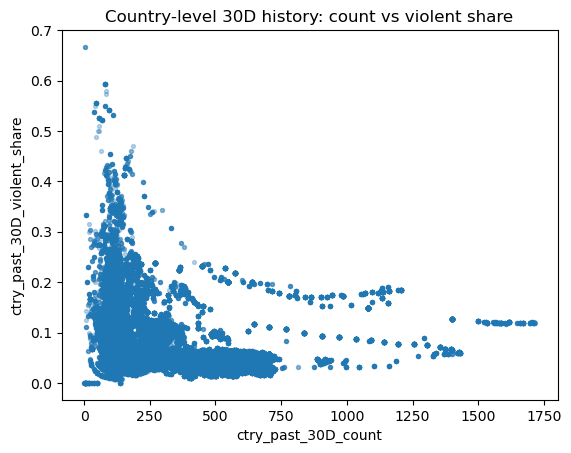

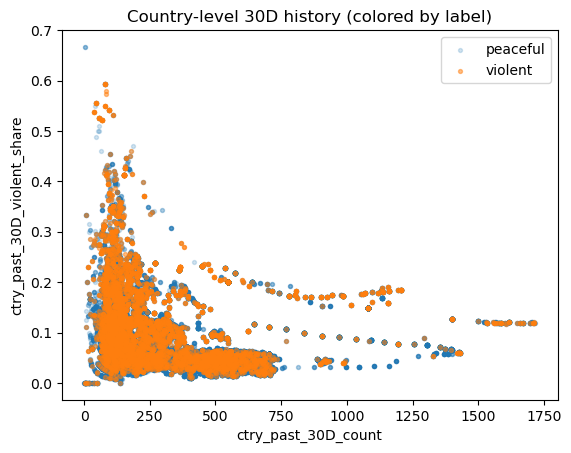

In [17]:
import matplotlib.pyplot as plt

y = "violent"

if {"ctry_past_30D_count","ctry_past_30D_violent_share"}.issubset(df_m.columns):
    plt.figure()
    plt.scatter(df_m["ctry_past_30D_count"], df_m["ctry_past_30D_violent_share"], s=8, alpha=0.3)
    plt.title("Country-level 30D history: count vs violent share")
    plt.xlabel("ctry_past_30D_count")
    plt.ylabel("ctry_past_30D_violent_share")
    plt.show()

    # colored by label (simple two scatters)
    plt.figure()
    m0 = df_m[y]==0
    m1 = df_m[y]==1
    plt.scatter(df_m.loc[m0,"ctry_past_30D_count"], df_m.loc[m0,"ctry_past_30D_violent_share"], s=8, alpha=0.2, label="peaceful")
    plt.scatter(df_m.loc[m1,"ctry_past_30D_count"], df_m.loc[m1,"ctry_past_30D_violent_share"], s=8, alpha=0.5, label="violent")
    plt.title("Country-level 30D history (colored by label)")
    plt.xlabel("ctry_past_30D_count")
    plt.ylabel("ctry_past_30D_violent_share")
    plt.legend()
    plt.show()

**Country-level 30D history: event volume vs violent share (two views).**  
The second plot colors points by the current label (`y_binary`), while the first plot shows the same scatter without coloring to emphasize the underlying geometry. Each point represents an event; the x-axis is the number of events in the prior 30 days (`ctry_past_30D_count`) and the y-axis is the fraction of those prior events labeled violent (`ctry_past_30D_violent_share`). The overall “triangle” pattern is largely mechanical: when the 30D count is small, the violent share has high variance because the denominator is small; as counts grow, the share becomes more stable and concentrates into a narrower band. Comparing the two views, violent-labeled events (orange) are somewhat more concentrated at higher recent violent shares, consistent with an escalation/diffusion intuition that recent violent environments increase the likelihood of a violent event. However, there is still substantial overlap between labels across most of the feature space, indicating these history features are informative but not sufficient alone for clean separation. 

## 6) Define feature space (X)

Before training models, we explicitly define the input feature set:

- **Categorical features** (e.g., `country`, `admin1`) require **one-hot encoding**.
- **Numeric features** (e.g., V-Dem, NTL, time features, rolling history) are used as-is after **imputation** and (for linear models) **scaling**.

We report:
- **Pre-encoding** feature count (categorical vs. numeric), to document what enters the model.
- **Post-encoding** feature dimension after OneHotEncoder, to ensure the feature space does not explode.

To reduce overfitting from extremely rare categories (especially in `admin1`), we set
`min_frequency` in OneHotEncoder so that infrequent categories are grouped rather than
creating many sparse dummy columns.

In [18]:
# choose columns (adapt if your df has more fields you want to include)
cat_cols = [c for c in ["country", "admin1"] if c in df_m.columns]

num_cols = [
    "v2x_libdem", "v2x_civlib",
    "ntl_mean_5km", "ntl_p90_5km", "ntl_std_5km",
    "month", "dow", "weekofyear",
    "city_days_since_prev_event",
    "city_same_day_count", "admin1_same_day_count",
    "ctry_past_30D_count", "ctry_past_30D_violent_share",
    "ctry_past_90D_count", "ctry_past_90D_violent_share",
]
num_cols = [c for c in num_cols if c in df_m.columns]

print(f"Pre-encoding features: {len(cat_cols)+len(num_cols)} total | {len(cat_cols)} categorical | {len(num_cols)} numeric")
print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Pre-encoding features: 14 total | 2 categorical | 12 numeric
Categorical: ['country', 'admin1']
Numeric: ['v2x_libdem', 'v2x_civlib', 'ntl_mean_5km', 'ntl_p90_5km', 'ntl_std_5km', 'month', 'dow', 'weekofyear', 'ctry_past_30D_count', 'ctry_past_30D_violent_share', 'ctry_past_90D_count', 'ctry_past_90D_violent_share']


### Feature set

We construct the modeling feature matrix using **14 predictors** in total:
- **2 categorical** variables: `country`, `admin1`
- **12 numeric** variables capturing institutions (V-Dem), development proxies (night-time lights), calendar effects, and recent protest history (rolling counts/shares).

Categorical:
- `country`
- `admin1`

Numeric:
- **Institutions (V-Dem):** `v2x_libdem`, `v2x_civlib`
- **Night-time lights (NTL, 5km):** `ntl_mean_5km`, `ntl_p90_5km`, `ntl_std_5km`
- **Calendar/time:** `month`, `dow`, `weekofyear`
- **Recent protest history (country-level, leakage-controlled):**
  - `ctry_past_30D_count`, `ctry_past_30D_violent_share`
  - `ctry_past_90D_count`, `ctry_past_90D_violent_share`

These are the **pre-encoding** features; categorical variables will later be one-hot encoded inside the preprocessing pipeline.

## 7) Split: train/val/test (temporal split as primary)

Primary split:
- Train: 2021–2022
- Val: 2023
- Test: 2024

This mimics forecasting and avoids training on future patterns.

In [19]:
# df_m: already filtered to 6 countries and 2021-2024, with feature engineering done

df_s = df_m.copy()

train_years = [2021, 2022]
val_years   = [2023]
test_years  = [2024]

train_df = df_s[df_s["year"].isin(train_years)].copy()
val_df   = df_s[df_s["year"].isin(val_years)].copy()
test_df  = df_s[df_s["year"].isin(test_years)].copy()

X_train = train_df[cat_cols + num_cols].copy()
y_train = train_df["violent"].copy()

X_val = val_df[cat_cols + num_cols].copy()
y_val = val_df["violent"].copy()

X_test = test_df[cat_cols + num_cols].copy()
y_test = test_df["violent"].copy()

print("Train:", X_train.shape, "violent share:", y_train.mean().round(4))
print("Val:  ", X_val.shape, "violent share:", y_val.mean().round(4))
print("Test: ", X_test.shape, "violent share:", y_test.mean().round(4))

Train: (36745, 14) violent share: 0.09
Val:   (16994, 14) violent share: 0.0715
Test:  (13348, 14) violent share: 0.0694


**Train/Validation/Test split (time-based).**  
We split the data by **year** to reflect a realistic forecasting setting and to reduce temporal leakage: **Train = 2021–2022**, **Validation = 2023**, **Test = 2024**. The splits contain 36,745 / 16,994 / 13,348 observations respectively, with the positive class (violent) share decreasing over time (Train ≈ 0.090, Val ≈ 0.0715, Test ≈ 0.0694). This indicates mild **distribution shift across years**, so we evaluate models using imbalance-aware metrics (Precision/Recall/F1, PR-AUC) and use class weighting where appropriate.

## 8) Preprocessing pipeline

We use a `ColumnTransformer`-based preprocessing pipeline so that all **data-dependent** transformations (imputation, encoding, scaling) are fit **only on the training set** within cross-validation, reducing the risk of data leakage.

- **Categorical features (`country`, `admin1`):**  
  Missing values → most-frequent imputation → one-hot encoding.  
  We set `min_frequency` to group very rare categories and avoid an excessively high-dimensional sparse design matrix.

- **Numeric features (V-Dem, NTL, time, rolling history):**  
  Median imputation → standardization (scaling is especially important for logistic regression so coefficients are comparable and optimization is stable).

- **NTL variables:**  
  We apply a `log1p` transform to reduce heavy right-skew in night-time light intensity measures.  
  *Implementation note:* this transform is applied consistently to the feature matrix (after the split). Because it does not learn parameters from the data, it does not introduce leakage; all learned steps (imputation/encoding/scaling) remain inside the pipeline.

In [20]:
# log1p transform for NTL (in X only)
for X in [X_train, X_val, X_test]:
    for c in ["ntl_mean_5km", "ntl_p90_5km", "ntl_std_5km"]:
        if c in X.columns:
            X[c] = np.log1p(X[c].clip(lower=0))

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=50))
])

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe, num_cols),
    ],
    remainder="drop"
)

### 8.1 Post-encoding feature dimension (sanity check)

This reports how many columns you end up with after one-hot encoding.

In [21]:
# fit + transform to get the final design matrix shape
Z_train = preprocess.fit_transform(X_train, y_train)
print("Post-preprocessing feature dimension:", Z_train.shape[1])

Post-preprocessing feature dimension: 135


**Post-preprocessing feature dimension.** After applying the preprocessing pipeline (imputation + one-hot encoding for categorical variables + scaling for numeric variables), the final design matrix has **135 features**. This increase from the 14 pre-encoding predictors is expected because categorical variables (especially `admin1`) expand into multiple dummy indicators after one-hot encoding. We use `min_frequency` in the encoder to group very rare categories and prevent the feature space from growing excessively.

PCA explained variance ratio: [0.2712 0.2102] | cumulative: 0.4814


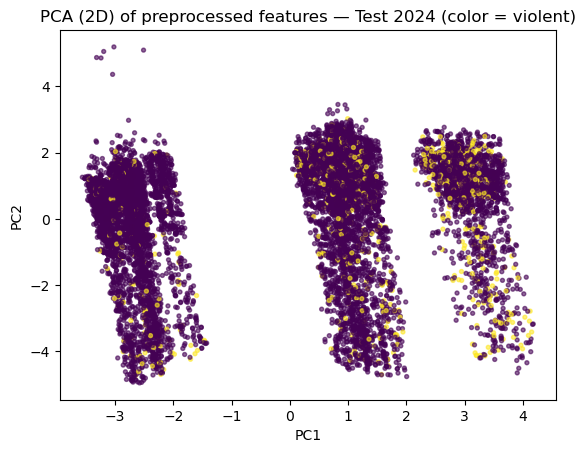

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1) Fit preprocessing on TRAIN only
Z_train = preprocess.fit_transform(X_train)
Z_val   = preprocess.transform(X_val)
Z_test  = preprocess.transform(X_test)

# 2) PCA on encoded features
pca = PCA(n_components=2, random_state=RANDOM_STATE)
P_train = pca.fit_transform(Z_train)
P_test  = pca.transform(Z_test)

print("PCA explained variance ratio:", np.round(pca.explained_variance_ratio_, 4),
      "| cumulative:", np.round(pca.explained_variance_ratio_.sum(), 4))

# 3) Plot (Test 2024)
plt.figure()
plt.scatter(P_test[:,0], P_test[:,1], s=8, alpha=0.6, c=y_test)
plt.title("PCA (2D) of preprocessed features — Test 2024 (color = violent)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

**PCA (2D) of preprocessed features — Test 2024 (colored by `violent`).** This plot projects the full (post-preprocessing) feature space into the first two principal components. The first two PCs explain about **48%** of the total variance (PC1 ≈ 27%, PC2 ≈ 21%). Visually, points form several distinct clusters, but **the violent (1) vs peaceful (0) labels overlap heavily within clusters**—there is no clean separation by the outcome in the top PCs. This suggests that the **largest sources of variation in the features are driven by structural differences across contexts (e.g., country/region and baseline protest intensity) rather than the violent label itself**, which is consistent with the idea that violence is a relatively rare “within-context” deviation.

PCA explained variance ratio: [0.2712 0.2102] | cumulative: 0.4814


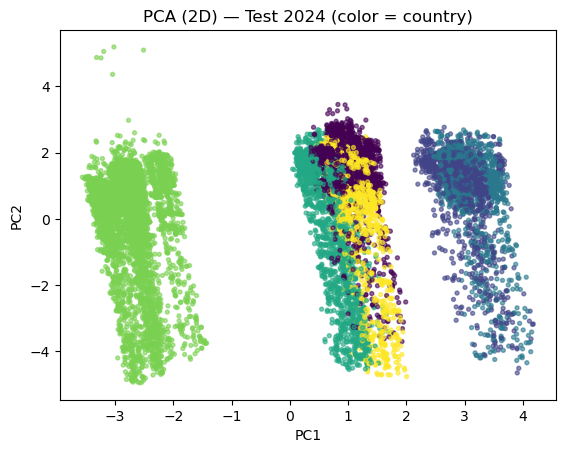

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- fit preprocess + PCA on TRAIN, transform TEST ----
Z_train = preprocess.fit_transform(X_train)
Z_test  = preprocess.transform(X_test)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
P_train = pca.fit_transform(Z_train)
P_test  = pca.transform(Z_test)

print("PCA explained variance ratio:",
      np.round(pca.explained_variance_ratio_, 4),
      "| cumulative:",
      np.round(pca.explained_variance_ratio_.sum(), 4))

# ---- build plotting dataframe (TEST) ----
pca_df = pd.DataFrame({
    "PC1": P_test[:, 0],
    "PC2": P_test[:, 1],
    "country": test_df["country"].astype(str).to_numpy(),
    "violent": y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test),
})

# ---- plot: color by country ----
plt.figure()
plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    s=8, alpha=0.6,
    c=pd.Categorical(pca_df["country"]).codes
)
plt.title("PCA (2D) — Test 2024 (color = country)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

**PCA (2D) of preprocessed features — Test 2024 (colored by `country`).** When we color the same PCA projection by country, the clusters align strongly with **country membership**: points from the same country concentrate in the same regions of the PC space, and several clusters are dominated by a single country. Since the first two PCs explain ~**48%** of total variance, this indicates that **between-country (and likely between-region) differences are a major driver of overall feature variation**. In other words, the data structure is largely “geographic/contextual” in the feature space, which helps explain why coloring by the `violent` label did not produce clean separation—violence is a rarer within-country outcome layered on top of strong country-level baselines and reporting patterns.

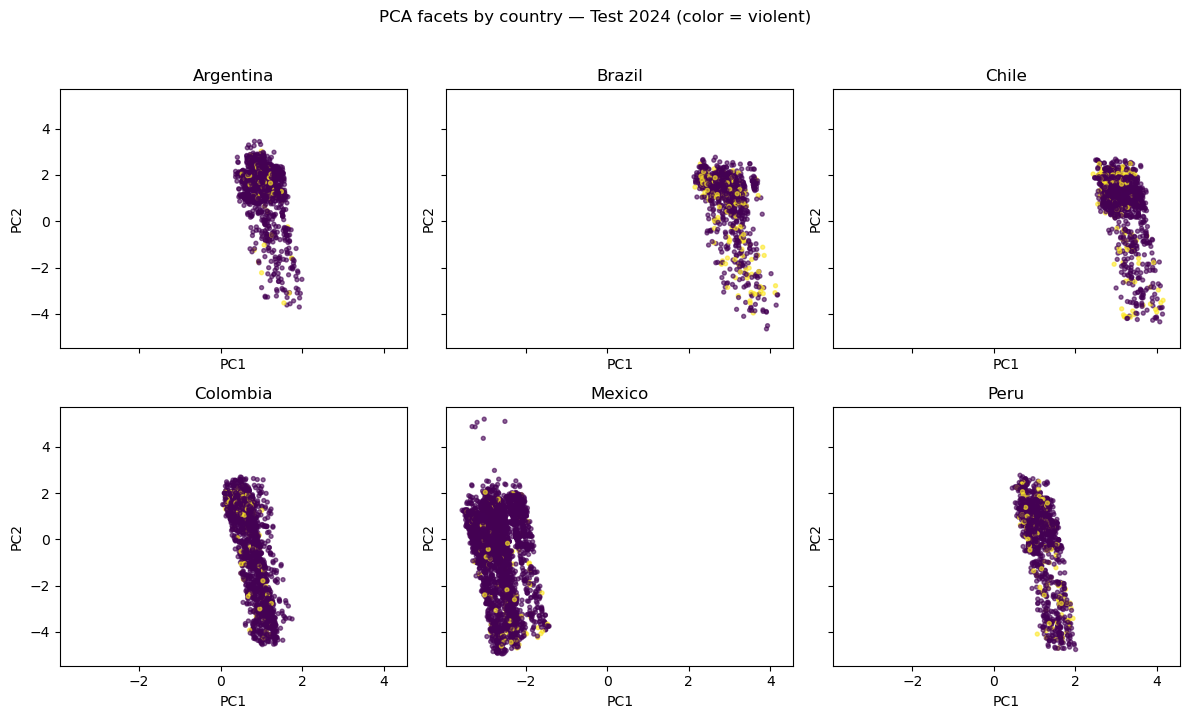

In [24]:
# ---- facet: one panel per country, color = violent ----
countries = sorted(pca_df["country"].unique())

n = len(countries)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 7), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for i, ctry in enumerate(countries):
    ax = axes[i]
    sub = pca_df[pca_df["country"] == ctry]
    ax.scatter(sub["PC1"], sub["PC2"], s=8, alpha=0.6, c=sub["violent"])
    ax.set_title(ctry)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# turn off extra axes if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("PCA facets by country — Test 2024 (color = violent)", y=1.02)
plt.tight_layout()
plt.show()

**PCA facets by country — Test 2024 (color = `violent`).** This faceted view makes the main takeaway clearer: **each country occupies a distinct region/shape in PCA space**, but **within each country panel the violent (1) points do not form a separate cluster**—they largely overlap with peaceful (0) points. That pattern suggests the first two principal components are capturing **cross-country structural differences** (baseline political context, measurement/reporting differences, urbanization proxies like NTL, and overall event intensity), while the `violent` label is a **within-country variation** that is harder to separate with only two PCs. In short: **PCA separation is mostly “country-driven,” not “violence-driven.”**

## 9) Baseline model (DummyClassifier)

Because the positive class is a minority, accuracy can be misleading.  
We include a naive baseline to show the minimum expected performance.

In [26]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

def eval_model(model, X, y):
    # class prediction
    pred = model.predict(X)

    # probability prediction (if available)
    proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

    out = {
        "accuracy": float(accuracy_score(y, pred)),
        "precision": float(precision_score(y, pred, zero_division=0)),
        "recall": float(recall_score(y, pred, zero_division=0)),
        "f1": float(f1_score(y, pred, zero_division=0)),
        "pred_pos_rate": float(np.mean(pred)),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    }

    # ranking metrics (need probabilities)
    if proba is not None and len(np.unique(y)) == 2:
        out["roc_auc"] = float(roc_auc_score(y, proba))
        out["pr_auc"]  = float(average_precision_score(y, proba))

    return out

**Baseline (DummyClassifier, `most_frequent`) results — Val/Test.**  
This “naive” model always predicts the majority class (peaceful = 0), so it achieves **high accuracy** 0.93 purely due to class imbalance. However, it **never predicts violent events** (`pred_pos_rate = 0`, `tp = 0`), which yields **precision/recall/F1 = 0** for the violent class. As expected for a non-informative classifier, **ROC-AUC = 0.5**, and **PR-AUC ≈ the base violent rate** (~0.07).  
We use this as a lower-bound reference: meaningful models should improve especially on **F1** and **PR-AUC** relative to this baseline.

## 10) Supervised model 1: Logistic Regression (linear)

We use logistic regression as an interpretable supervised baseline.  
We evaluate with a **year-based split** (Train 2021–2022 / Val 2023 / Test 2024) to avoid temporal leakage.

- **Preprocessing** is fit on Train only via a Pipeline (impute + scale + one-hot).
- Because the target is imbalanced, we set `class_weight="balanced"` and tune `C` using **F1** on Val.
- We report **F1 / Precision / Recall** and **PR-AUC** (primary under imbalance), plus ROC-AUC for ranking.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd

C_grid = [0.1, 0.3, 1.0, 3.0, 10.0]
rows = []

for C in C_grid:
    lr = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(
            C=C,
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ])
    lr.fit(X_train, y_train)
    m_val = eval_model(lr, X_val, y_val)
    rows.append({"C": C, **m_val})

lr_val_table = pd.DataFrame(rows).sort_values("f1", ascending=False)
lr_val_table[["C","f1","precision","recall","pr_auc","roc_auc","pred_pos_rate"]]

,C,f1,precision,recall,pr_auc,roc_auc,pred_pos_rate
0,0.1,0.193899,0.120293,0.499588,0.162530,0.672859,0.296928
1,0.3,0.190879,0.117886,0.501235,0.159127,0.667691,0.303990
4,10.0,0.189089,0.116479,0.502058,0.157357,0.665102,0.308168
3,3.0,0.187433,0.115225,0.502058,0.155446,0.662907,0.311522
2,1.0,0.186971,0.115006,0.499588,0.155473,0.662929,0.310580


**Logistic Regression sensitivity to regularization (Validation 2023).**  
We fit the same pipeline with different values of the regularization strength `C` and evaluate on the 2023 validation year. Results are fairly stable across `C`, suggesting the model is not highly sensitive to this hyperparameter in our setting. Using `class_weight="balanced"` increases the predicted positive rate (≈0.30), which boosts recall but lowers precision—consistent with the class imbalance in the target.

In [28]:
best_C = lr_val_table.iloc[0]["C"]
best_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        C=float(best_C),
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
]).fit(X_train, y_train)

lr_test = eval_model(best_lr, X_test, y_test)
lr_test

{'accuracy': 0.7244531015882529,
 'precision': 0.14129301355578727,
 'recall': 0.5853131749460043,
 'f1': 0.22763544729105417,
 'pred_pos_rate': 0.28738387773449203,
 'tn': 9128,
 'fp': 3294,
 'fn': 384,
 'tp': 542,
 'roc_auc': 0.7121964166550463,
 'pr_auc': 0.15825714742318653}

**Logistic Regression (best C from Validation) — Test 2024 results.**  
Using the best `C` selected on the 2023 validation year, we refit the model on Train (2021–2022) and evaluate on Test (2024). The model achieves **high recall (0.585)** but **low precision (0.141)**, consistent with using `class_weight="balanced"` under a highly imbalanced target (~7% violent). This setting reduces false negatives but produces many false positives (predicted positive rate ≈ 0.287). Ranking metrics remain strong (ROC-AUC ≈ 0.712, PR-AUC ≈ 0.158), indicating meaningful separation above the base rate.

### 10.1 Tuning evidence: `C` vs mean CV F1

This plot shows how the regularization affects performance (evidence-based selection).

,C,mean_test_score,std_test_score,rank_test_score
3,0.1,0.262332,0.011863,4
4,0.3,0.261652,0.010709,5
1,1.0,0.262598,0.010266,2
2,3.0,0.262516,0.010232,3
0,10.0,0.263096,0.009823,1


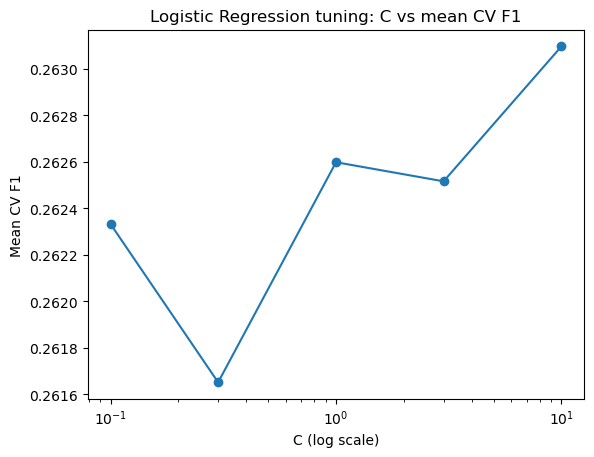

Best params: {'clf__C': 10.0}


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

logit = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid = {"clf__C": [0.1, 0.3, 1.0, 3.0, 10.0]}

logit_gs = GridSearchCV(logit, param_grid, scoring="f1", cv=3, n_jobs=-1, refit=True)
logit_gs.fit(X_train, y_train)

logit_tune = (
    pd.DataFrame(logit_gs.cv_results_)
      .sort_values("rank_test_score")
      .reset_index(drop=True)
)

plot_df = logit_tune.copy()
plot_df["C"] = plot_df["params"].apply(lambda d: d["clf__C"])
plot_df = plot_df.sort_values("C")

display(plot_df[["C", "mean_test_score", "std_test_score", "rank_test_score"]])

plt.figure()
plt.plot(plot_df["C"], plot_df["mean_test_score"], marker="o")
plt.xscale("log")
plt.title("Logistic Regression tuning: C vs mean CV F1")
plt.xlabel("C (log scale)")
plt.ylabel("Mean CV F1")
plt.show()

print("Best params:", logit_gs.best_params_)

In [30]:
logit_best = logit_gs.best_estimator_
print("Best params:", logit_gs.best_params_)

print("Val(2023):", eval_model(logit_best, X_val, y_val))
print("Test(2024):", eval_model(logit_best, X_test, y_test))

Best params: {'clf__C': 10.0}
Val(2023): {'accuracy': 0.6921266329292691, 'precision': 0.11647890013366431, 'recall': 0.5020576131687243, 'f1': 0.18908865468071917, 'pred_pos_rate': 0.30816758856066845, 'tn': 11152, 'fp': 4627, 'fn': 605, 'tp': 610, 'roc_auc': 0.6651021034625122, 'pr_auc': 0.15735716506278158}
Test(2024): {'accuracy': 0.6978573569074018, 'precision': 0.13090995485863627, 'recall': 0.5950323974082073, 'f1': 0.21460564751703992, 'pred_pos_rate': 0.31532813904704826, 'tn': 8764, 'fp': 3658, 'fn': 375, 'tp': 551, 'roc_auc': 0.7000634281893094, 'pr_auc': 0.15045822985894855}


### Logistic Regression (best C) — Validation & Test performance

**Best hyperparameter.**  
Cross-validation on the training period selected **`C = 10.0`** (weaker L2 regularization), which gave the highest mean CV F1 in our grid.

**Validation (2023) vs. Test (2024).**  
We evaluate the tuned model on the held-out years:

- **Val(2023)**:  
  - Precision = **0.116**, Recall = **0.502**, F1 = **0.189**  
  - ROC-AUC = **0.665**, PR-AUC = **0.157**  
  - Confusion matrix counts: **TP=610**, **FP=4627**, **FN=605**, **TN=11152**

- **Test(2024)**:  
  - Precision = **0.131**, Recall = **0.595**, F1 = **0.215**  
  - ROC-AUC = **0.700**, PR-AUC = **0.150**  
  - Confusion matrix counts: **TP=551**, **FP=3658**, **FN=375**, **TN=8764**

**How to interpret these numbers (especially under imbalance).**  
- The dataset is imbalanced, so **accuracy (~0.69)** is not the key metric (a majority-class baseline can be ~0.93).  
- This model achieves **moderate recall (~0.50–0.60)**, meaning it identifies a non-trivial share of violent events, but at the cost of **low precision (~0.12–0.13)**, i.e., many predicted “violent” events are actually peaceful (**FP is large**).  
- `pred_pos_rate ≈ 0.31` shows the model predicts “violent” for about 31% of cases, which is much higher than the true violent rate (~7–9%). This is consistent with prioritizing recall under class weighting / F1 optimization.

**Takeaway.**  
The tuned logistic regression provides a meaningful improvement over the dummy baseline by learning a ranking signal (**ROC-AUC ~0.67–0.70; PR-AUC ~0.15–0.16**), but its default threshold yields many false positives.  
In later analysis, we can (optionally) adjust the decision threshold depending on whether the priority is **catching more violent events (recall)** or **reducing false alarms (precision)**.

## 11) Supervised model 2: Random Forest (tree-based)

We tune:
- `n_estimators`
- `max_depth`
- `min_samples_leaf`

We again optimize F1 for imbalanced classification.

In [31]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 8, 16],
    "clf__min_samples_leaf": [1, 5, 10],
}

rf_gs = GridSearchCV(
    rf,
    rf_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=0,
    refit=True
)

rf_gs.fit(X_train, y_train)
rf_tune = pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score")
rf_tune[["params","mean_test_score","std_test_score","rank_test_score"]].head(12)

,params,mean_test_score,std_test_score,rank_test_score
17,"{'clf__max_depth': 16, 'clf__min_samples_leaf'...",0.271684,0.016202,1
16,"{'clf__max_depth': 16, 'clf__min_samples_leaf'...",0.271172,0.016217,2
5,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.265906,0.013899,3
4,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.263226,0.015134,4
7,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.262371,0.022006,5
9,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.261770,0.023439,6
8,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.261472,0.022768,7
11,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.258865,0.020759,8
6,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.257981,0.019869,9
10,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",0.255801,0.019259,10


In [32]:
rf_best = rf_gs.best_estimator_
print("Best params:", rf_gs.best_params_)

print("Val(2023):", eval_model(rf_best, X_val, y_val))
print("Test(2024):", eval_model(rf_best, X_test, y_test))

Best params: {'clf__max_depth': 16, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 400}
Val(2023): {'accuracy': 0.8395315993880194, 'precision': 0.17966101694915254, 'recall': 0.34897119341563787, 'f1': 0.23720279720279722, 'pred_pos_rate': 0.13887254325055903, 'tn': 13843, 'fp': 1936, 'fn': 791, 'tp': 424, 'roc_auc': 0.6882451724527339, 'pr_auc': 0.18231006663947907}
Test(2024): {'accuracy': 0.8289631405454001, 'precision': 0.16691212567501226, 'recall': 0.367170626349892, 'f1': 0.2294971312858589, 'pred_pos_rate': 0.1526071321546299, 'tn': 10725, 'fp': 1697, 'fn': 586, 'tp': 340, 'roc_auc': 0.7121076554416622, 'pr_auc': 0.1586755403109572}


### Random Forest (best hyperparameters) — Validation & Test performance

**Best hyperparameters.**  
Grid search on the training period selected:

- `max_depth = 16`  
- `min_samples_leaf = 10`  
- `n_estimators = 400`

These settings intentionally **regularize** the forest (especially `min_samples_leaf=10`) to reduce overfitting and improve generalization.

## Validation (2023)

- Accuracy = **0.840**  
- Precision = **0.180**, Recall = **0.349**, F1 = **0.237**  
- ROC-AUC = **0.688**, PR-AUC = **0.182**
- Confusion matrix counts: **TP=424**, **FP=1936**, **FN=791**, **TN=13843**
- `pred_pos_rate = 0.139` → the model predicts “violent” for ~14% of cases (closer to the true violent rate than logistic regression).

## Test (2024)

- Accuracy = **0.829**  
- Precision = **0.167**, Recall = **0.367**, F1 = **0.229**  
- ROC-AUC = **0.712**, PR-AUC = **0.159**
- Confusion matrix counts: **TP=340**, **FP=1697**, **FN=586**, **TN=10725**
- `pred_pos_rate = 0.153` → predicts “violent” for ~15% of cases.

### How to interpret (vs Logistic Regression)

Compared to logistic regression, the tuned Random Forest is **more conservative**:

- It predicts “violent” much less often (**~14–15% vs ~31%**), so it produces **fewer false positives** (higher precision).
- But it also misses more true violent events (lower recall).

**Summary:**
- **Random Forest:** better precision / fewer false alarms, slightly higher F1 on validation; PR-AUC also competitive.  
- **Logistic Regression:** higher recall (catches more violent events) but many more false positives.

**Takeaway.**  
Random Forest shows a stronger balance between false alarms and missed violent events at the default threshold, and it still provides meaningful ranking quality (**ROC-AUC ~0.69–0.71; PR-AUC ~0.16–0.18**). 

Overall, I select **Random Forest** as the primary supervised model.

### 11.1 Tuning evidence: effects of depth/leaf size

We summarize mean CV F1 by key hyperparameters to show the exploration logic.

min_leaf,1,5,10
max_depth,,,
8,0.260176,0.261621,0.257333
16,0.090840,0.242912,0.271428
None,0.037153,0.213238,0.264566


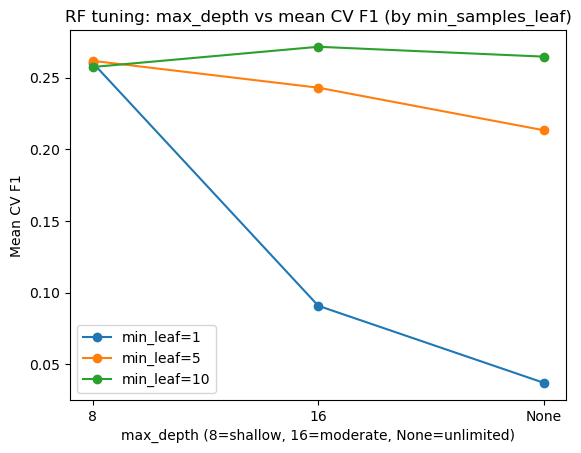

Best params: {'clf__max_depth': 16, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 400}


In [33]:
# Extract grid columns
rf_tune["max_depth"] = rf_tune["param_clf__max_depth"].astype(str)
rf_tune["min_leaf"]  = rf_tune["param_clf__min_samples_leaf"].astype(int)

pivot = rf_tune.pivot_table(
    index="max_depth",
    columns="min_leaf",
    values="mean_test_score",
    aggfunc="mean"
)

# enforce a sensible order for plotting
order = ["8", "16", "None"]
pivot = pivot.reindex(order)

display(pivot)

plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=f"min_leaf={col}")
plt.title("RF tuning: max_depth vs mean CV F1 (by min_samples_leaf)")
plt.xlabel("max_depth (8=shallow, 16=moderate, None=unlimited)")
plt.ylabel("Mean CV F1")
plt.legend()
plt.show()

print("Best params:", rf_gs.best_params_)

**Random Forest hyperparameter tuning (CV F1).**  
This plot compares mean cross-validated **F1** across different tree depths (`max_depth`) and minimum leaf sizes (`min_samples_leaf`). Two patterns stand out:

- **Very small leaves (min_leaf = 1)** perform poorly—especially with deeper/unlimited trees—suggesting **overfitting** (the model memorizes noise in the minority class and fails to generalize).
- **Larger leaves (min_leaf = 10)** consistently yield the best or near-best F1, and performance peaks around **moderate depth (max_depth ≈ 16)**, which balances flexibility with regularization.

Overall, the best setting (`max_depth=16`, `min_samples_leaf=10`) indicates the model benefits from **regularization via smoother trees** rather than fully unconstrained growth.

## 12) Evaluate models on the held-out test set

We evaluate:
- baseline (Dummy)
- logistic regression (best)
- random forest (best)

Metrics:
- Accuracy (for completeness, but not sufficient)
- Precision / Recall / F1
- ROC-AUC (ranking quality)
- PR-AUC (more informative under imbalance)

In [34]:
models = {
    "Dummy(most_frequent)": dummy,
    "LogisticRegression(best)": logit_best,
    "RandomForest(best)": rf_best
}

test_results = pd.DataFrame({name: eval_model(m, X_test, y_test) for name, m in models.items()}).T
test_results

,accuracy,precision,recall,f1,pred_pos_rate,tn,fp,fn,tp,roc_auc,pr_auc
Dummy(most_frequent),0.930626,0.000000,0.000000,0.000000,0.000000,12422.0,0.0,926.0,0.0,0.500000,0.069374
LogisticRegression(best),0.697857,0.130910,0.595032,0.214606,0.315328,8764.0,3658.0,375.0,551.0,0.700063,0.150458
RandomForest(best),0.828963,0.166912,0.367171,0.229497,0.152607,10725.0,1697.0,586.0,340.0,0.712108,0.158676


**Held-out test set (2024) performance comparison (higher is better for F1 / PR-AUC / ROC-AUC).**  
This table benchmarks two supervised models against a simple baseline:

- **Dummy (most_frequent)** always predicts the majority class (peaceful). It achieves high **accuracy (~0.93)** purely because the data are imbalanced, but it has **0 precision/recall/F1** for violent events and **ROC-AUC = 0.5** (random ranking). This confirms accuracy is not a meaningful metric here.

- **Logistic Regression (best)** substantially increases **recall (~0.60)**, meaning it catches more violent events, but it predicts “violent” relatively often (**pred_pos_rate ~0.32**), producing many false positives and therefore lower precision.

- **Random Forest (best)** provides the best overall balance on this task: it improves **F1 (~0.229)** and **PR-AUC (~0.159)** relative to logistic regression, while keeping the predicted positive rate lower (**~0.15**).  
Given the class imbalance and our emphasis on identifying violent events with reasonable precision, we treat **F1 and PR-AUC** as the primary metrics and use this table to motivate selecting **Random Forest** as the preferred supervised model.

## 13) Precision–Recall curve & threshold discussion (imbalanced classification)

Because **violent events are rare**, overall **accuracy** can look high even for a trivial model, and the default decision threshold (**0.5**) is often not aligned with what we care about.  
Instead, we evaluate models using the **Precision–Recall (PR) curve** and **PR-AUC (Average Precision)**, which focus on performance on the minority class.

**Threshold trade-off (how to interpret the PR curve):**
- If the goal is **early warning / not missing violent escalations**, we prefer **higher recall** → use a **lower threshold** (accept more false positives).
- If the goal is **high-confidence violent flags**, we prefer **higher precision** → use a **higher threshold** (accept more false negatives).

We therefore plot **PR curves on the test set** to visualize the full precision–recall trade-off, and report **PR-AUC** as a summary measure of ranking quality under class imbalance.

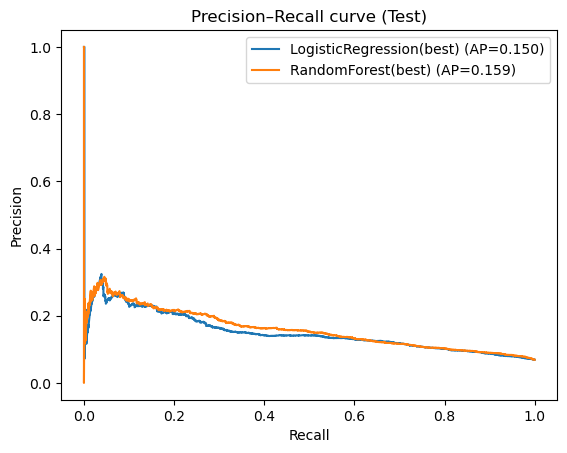

In [35]:
plt.figure()
for name, m in models.items():
    if hasattr(m, "predict_proba") and name != "Dummy(most_frequent)":
        proba = m.predict_proba(X_test)[:,1]
        prec, rec, thr = precision_recall_curve(y_test, proba)
        ap = average_precision_score(y_test, proba)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.title("Precision–Recall curve (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.show()

### Precision–Recall curve (Test set, 2024)

Because the positive class (**violent=1**) is relatively rare (~7–9%), the **Precision–Recall (PR) curve** is more informative than accuracy (and often more diagnostic than ROC-AUC).  
Each point on the curve corresponds to a different **decision threshold** on the predicted probability of violence:

- Moving **right** increases **recall** (catch more violent events) but usually lowers **precision** (more false alarms).
- Moving **left** increases **precision** (higher-confidence “violent” flags) but misses more violent events (lower recall).

In this test set, the two models have **similar PR curves**, with **Random Forest slightly higher** overall (AP≈0.159) than Logistic Regression (AP≈0.150), suggesting a small improvement in ranking/picking out violent events under class imbalance.  

## 14) Interpretation — coefficients (Logistic Regression)

We examine the largest positive/negative coefficients.  
Because we one-hot encode categories, coefficients include numeric features and dummy variables.

In [36]:
# Pull feature names after preprocessing
ohe = logit_best.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols)>0 else np.array([])
num_feature_names = np.array(num_cols)
all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

coefs = logit_best.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs}).sort_values("coef", ascending=False)

display(coef_df.head(15))
display(coef_df.tail(15))

,feature,coef
70,admin1_Metropolitana,2.718812
7,admin1_Alagoas,1.670408
83,admin1_Pernambuco,1.549396
31,admin1_Chiapas,1.424154
63,admin1_Los Rios,1.410318
21,admin1_Biobio,1.382842
79,admin1_Oaxaca,1.315018
113,admin1_Tlaxcala,1.291149
72,admin1_Michoacan de Ocampo,1.242564
12,admin1_Araucania,1.204311


,feature,coef
95,admin1_Roraima,-0.897718
76,admin1_Neuquen,-0.931509
20,admin1_Baja California Sur,-1.021563
69,admin1_Mendoza,-1.021725
49,admin1_Guanajuato,-1.095833
99,admin1_San Luis Potosi,-1.145566
106,admin1_Sinaloa,-1.146903
45,admin1_Durango,-1.339592
62,admin1_Los Lagos,-1.348059
68,admin1_Maule,-1.348620


### Interpretation check: Logistic Regression coefficients

The top positive/negative coefficients are dominated by one-hot encoded **admin1** categories (e.g., `admin1_Metropolitana`, `admin1_Choco`, `admin1_Zacatecas`).  
This suggests the linear model is largely leveraging **location fixed effects** (i.e., “which admin1 is this event in?”) rather than the mechanism-focused covariates we care about (e.g., diffusion/history, NTL, political context).

Because `admin1` can be highly correlated with country and with conflict history features (and may encourage overfitting to geography), we also run a specification **excluding `admin1`** and re-check performance + coefficients. This helps ensure the model interpretation aligns with the research question (drivers of escalation risk) rather than simply memorizing places.

In [37]:
# what if keep only country (drop admin1)?
cat_cols_no_admin = [c for c in ["country"] if c in df_m.columns]

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=50))
])

preprocess_no_admin = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols_no_admin),
        ("num", num_pipe, num_cols),
    ],
    remainder="drop"
)

logit_no_admin = Pipeline(steps=[
    ("preprocess", preprocess_no_admin),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

logit_no_admin.fit(X_train[cat_cols_no_admin + num_cols], y_train)
print("Val:", eval_model(logit_no_admin, X_val[cat_cols_no_admin + num_cols], y_val))
print("Test:", eval_model(logit_no_admin, X_test[cat_cols_no_admin + num_cols], y_test))

Val: {'accuracy': 0.7004825232434977, 'precision': 0.09744442135881987, 'recall': 0.3860082304526749, 'f1': 0.15560716655607165, 'pred_pos_rate': 0.28321760621395786, 'tn': 11435, 'fp': 4344, 'fn': 746, 'tp': 469, 'roc_auc': 0.6093649500808102, 'pr_auc': 0.10065036848194453}
Test: {'accuracy': 0.7159874138447707, 'precision': 0.10742669224445053, 'recall': 0.42332613390928725, 'f1': 0.17136612021857925, 'pred_pos_rate': 0.27337428828288884, 'tn': 9165, 'fp': 3257, 'fn': 534, 'tp': 392, 'roc_auc': 0.6430120496172574, 'pr_auc': 0.1068783868222164}


### Sensitivity check: removing admin1 (potentially over-specific geographic dummies)

To reduce the risk that the model is primarily learning **location fixed effects** (admin1 one-hot dummies),
we re-fit Logistic Regression using only `country` as categorical input (dropping `admin1`).

Performance decreases (Val/Test F1 and PR-AUC drop noticeably), which suggests that `admin1` contains strong
predictive signal. However, this signal may reflect **place-specific patterns** rather than the mechanism
variables we focus on (diffusion/history, night-time lights, political context).  

We therefore treat the `admin1`-free specification as a more conservative model aligned with the research
question, and we keep the Random Forest (which performs better on PR-AUC/F1) as the main supervised model.

## 15) Interpretation — feature importance (Random Forest)

Random forest gives impurity-based feature importances (not causal effects).  
They help identify which signals the model relied on most.

,feature,importance
134,ctry_past_90D_violent_share,0.117209
132,ctry_past_30D_violent_share,0.110807
126,ntl_p90_5km,0.073162
125,ntl_mean_5km,0.070069
127,ntl_std_5km,0.068521
133,ctry_past_90D_count,0.066478
131,ctry_past_30D_count,0.064443
123,v2x_libdem,0.046743
130,weekofyear,0.044060
129,dow,0.037643


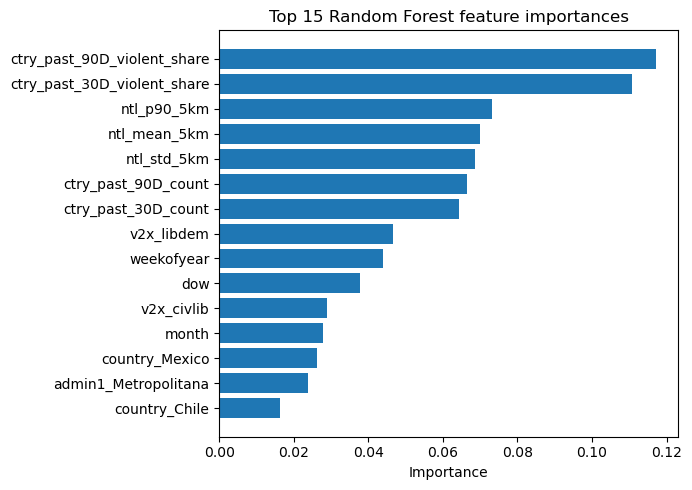

In [38]:
rf_clf = rf_best.named_steps["clf"]
importances = rf_clf.feature_importances_
imp_df = pd.DataFrame({"feature": all_feature_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(20))

plt.figure(figsize=(7,5))
topk = 15
plt.barh(imp_df.head(topk)["feature"][::-1], imp_df.head(topk)["importance"][::-1])
plt.title("Top 15 Random Forest feature importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Random Forest feature importance (top 15).**  
The model relies most on **recent protest violence history at the country level**, especially `ctry_past_90D_violent_share` and `ctry_past_30D_violent_share`. This supports the core intuition of our research design: protest violence is not memoryless—recent violence patterns may capture **temporal dependence / diffusion** (e.g., heightened repression, mobilization dynamics, or tactical escalation following earlier violent events).  

The next most important predictors are **night-time lights (NTL)** around the event location (`ntl_p90_5km`, `ntl_mean_5km`, `ntl_std_5km`), which likely proxy for **urbanization / economic activity / population density**—contexts where protest dynamics and policing capacity differ.  

We also see moderate importance for **overall protest intensity/history** (`ctry_past_90D_count`, `ctry_past_30D_count`) and **political context** (`v2x_libdem`, `v2x_civlib`). Finally, calendar features (`weekofyear`, `dow`, `month`) contribute smaller but non-zero signal, suggesting weak seasonality or weekday patterns.  

**Note:** these importances are *impurity-based* and should be interpreted as “which signals the model uses” rather than causal effects; correlated variables can share importance, and categorical dummies (e.g., `country_*`, `admin1_*`) may partly reflect persistent location-specific baseline risk.

## 16) Tree visualization (interpretable proxy)

A Random Forest is an ensemble of hundreds of decision trees, so it is not practical to visualize the full model directly.  
To make the tree-based decision logic easier to interpret, we fit a **small / shallow DecisionTreeClassifier** on the same feature set and visualize it.

- This tree is an **interpretable proxy** (it shows *plausible* split rules the forest may be using),
- but it is **not** the final model and **not** used to claim performance.
- The goal here is **model interpretability** (what kinds of features and thresholds separate violent vs peaceful cases).

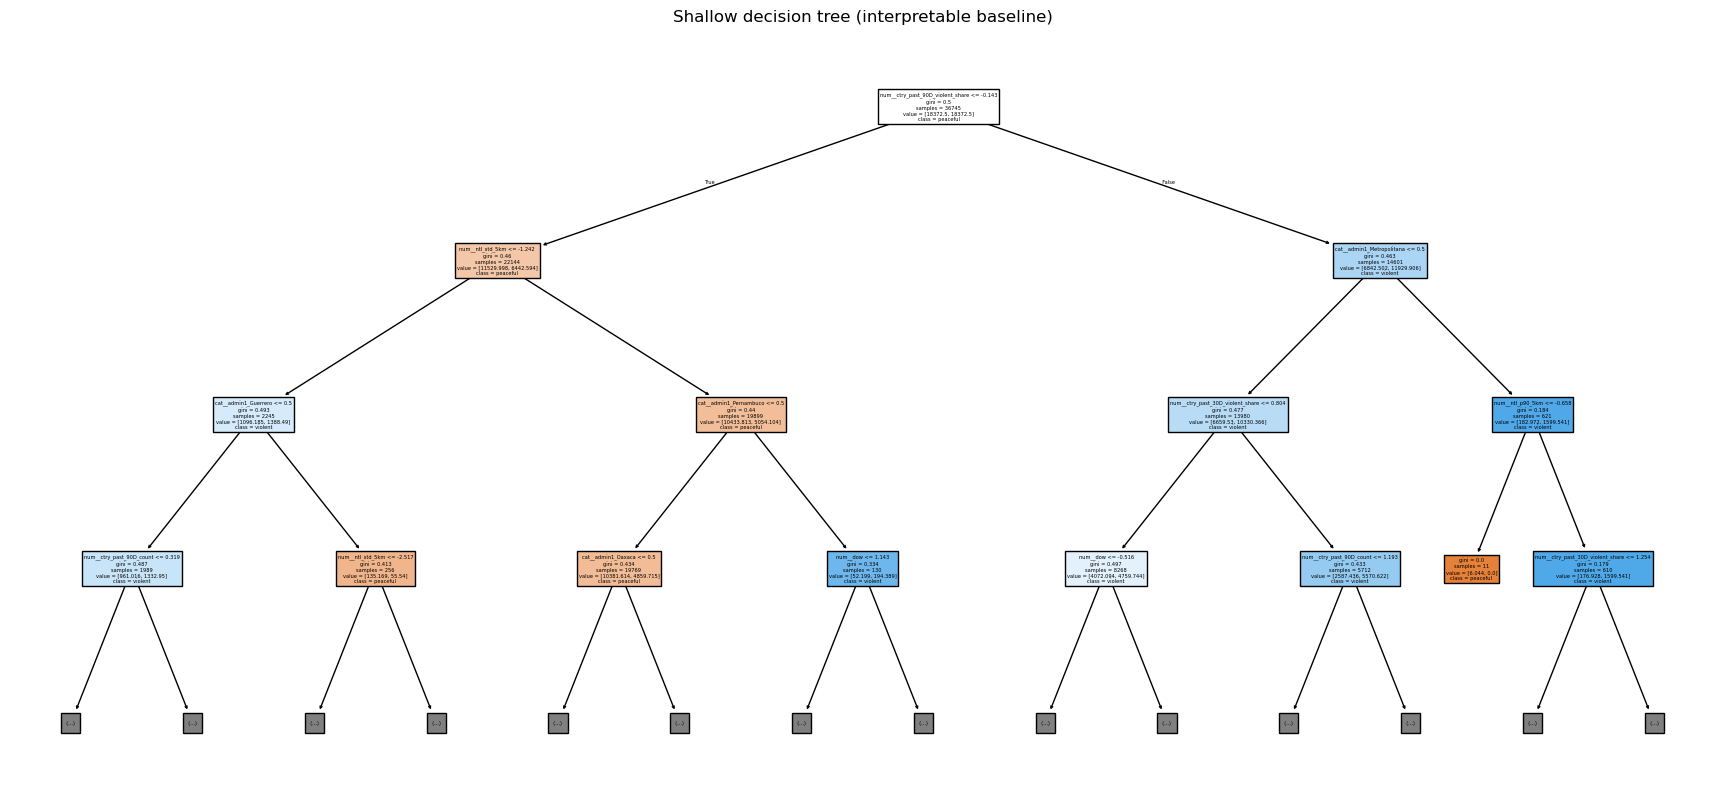

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1) fit preprocess on train
preprocess.fit(X_train)

# 2) transform train -> encoded matrix
X_train_enc = preprocess.transform(X_train)

# 3) get exact feature names from preprocess (matches encoded matrix)
feat_names = preprocess.get_feature_names_out()

# 4) fit an interpretable small tree on the encoded features
tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
tree.fit(X_train_enc, y_train)

# 5) plot
plt.figure(figsize=(22,10))
plot_tree(
    tree,
    feature_names=feat_names,
    class_names=["peaceful", "violent"],
    filled=True,
    max_depth=3
)
plt.title("Shallow decision tree (interpretable baseline)")
plt.show()

## 17) Error analysis

We inspect misclassified examples from the test set for **both** LR and RF:
- False Positives (predict violent but true peaceful)
- False Negatives (predict peaceful but true violent)
- High-confidence mistakes (p close to 0 or 1 but wrong)

This helps connect errors to:
- noisy / ambiguous labeling
- sparse categories (rare places)
- missing NTL or weak history signals
- model strengths/weaknesses (linear vs non-linear)

In [40]:
def error_table(model, df_raw, X, y, top_n=10):
    
    pred = model.predict(X)
    proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    err_df = df_raw.copy()
    err_df["y_true"] = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)
    err_df["y_pred"] = pred
    if proba is not None:
        err_df["p_violent"] = proba

    fp = err_df[(err_df["y_true"] == 0) & (err_df["y_pred"] == 1)].copy()
    fn = err_df[(err_df["y_true"] == 1) & (err_df["y_pred"] == 0)].copy()

    if "p_violent" in err_df.columns:
        fp = fp.sort_values("p_violent", ascending=False).head(top_n)
        fn = fn.sort_values("p_violent", ascending=True).head(top_n)
    else:
        fp = fp.head(top_n)
        fn = fn.head(top_n)

    show_cols = [c for c in [
        "event_date", "country", "admin1", "location",
        "v2x_libdem", "v2x_civlib",
        "ntl_mean_5km", "ntl_p90_5km", "ntl_std_5km",
        "ctry_past_30D_violent_share", "ctry_past_90D_violent_share",
        "ctry_past_30D_count", "ctry_past_90D_count",
        "month", "dow", "weekofyear",
        "p_violent", "y_true", "y_pred"
    ] if c in err_df.columns]

    return fp[show_cols], fn[show_cols]

for name in ["LogisticRegression(best)", "RandomForest(best)"]:
    m = models[name]
    fp, fn = error_table(m, test_df, X_test, y_test, top_n=10)
    print("\n===", name, "===")
    print("False Positives (top confidence):")
    display(fp)
    print("False Negatives (top confidence):")
    display(fn)


=== LogisticRegression(best) ===
False Positives (top confidence):


,event_date,country,admin1,location,v2x_libdem,v2x_civlib,ntl_mean_5km,ntl_p90_5km,ntl_std_5km,ctry_past_30D_violent_share,ctry_past_90D_violent_share,ctry_past_30D_count,ctry_past_90D_count,month,dow,weekofyear,p_violent,y_true,y_pred
61653,2024-08-13,Chile,Metropolitana,Lampa,0.787,0.932,6.301688,19.642717,7.498929,0.251256,0.180905,199.0,398.0,8,1,33,0.926017,0,1
61627,2024-08-12,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.248780,0.172494,205.0,429.0,8,0,33,0.915078,0,1
61629,2024-08-12,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.248780,0.172494,205.0,429.0,8,0,33,0.915078,0,1
63686,2024-09-30,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.187500,0.173536,96.0,461.0,9,0,40,0.905166,0,1
62190,2024-08-26,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.200000,0.159091,220.0,440.0,8,0,35,0.904517,0,1
62147,2024-08-26,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.200000,0.159091,220.0,440.0,8,0,35,0.904517,0,1
53902,2024-01-09,Chile,Metropolitana,Melipilla,0.787,0.932,7.357375,23.955840,9.467669,0.205128,0.120805,78.0,298.0,1,1,2,0.903541,0,1
61377,2024-08-06,Chile,Metropolitana,Lampa,0.787,0.932,6.301688,19.642717,7.498929,0.165605,0.132432,157.0,370.0,8,1,32,0.902608,0,1
58398,2024-05-14,Chile,Metropolitana,El Paico,0.787,0.932,2.096536,5.268402,2.150321,0.108333,0.132964,120.0,361.0,5,1,20,0.902304,0,1
61435,2024-08-07,Chile,Metropolitana,Lampa,0.787,0.932,6.301688,19.642717,7.498929,0.186047,0.145119,172.0,379.0,8,2,32,0.902110,0,1


False Negatives (top confidence):


,event_date,country,admin1,location,v2x_libdem,v2x_civlib,ntl_mean_5km,ntl_p90_5km,ntl_std_5km,ctry_past_30D_violent_share,ctry_past_90D_violent_share,ctry_past_30D_count,ctry_past_90D_count,month,dow,weekofyear,p_violent,y_true,y_pred
55991,2024-03-08,Mexico,Colima,Colima,0.251,0.598,22.866644,34.331175,11.399921,0.021314,0.032958,563.0,1244.0,3,4,10,0.007718,1,0
63266,2024-09-18,Colombia,Choco,Quibdo,0.557,0.743,3.381683,11.303435,4.017457,0.054608,0.059813,293.0,535.0,9,2,38,0.009382,1,0
66884,2024-12-17,Mexico,Colima,Colima,0.251,0.598,22.866644,34.331175,11.399921,0.023158,0.026059,475.0,1535.0,12,1,51,0.012246,1,0
65493,2024-11-11,Mexico,Colima,Colima,0.251,0.598,22.866644,34.331175,11.399921,0.025097,0.028994,518.0,1759.0,11,0,46,0.013344,1,0
54191,2024-01-17,Mexico,Sonora,Huatabampo,0.251,0.598,4.460783,12.573147,6.277532,0.044828,0.035223,290.0,1164.0,1,2,3,0.071503,1,0
60287,2024-07-04,Mexico,Durango,Lerdo,0.251,0.598,23.973439,54.395659,20.013545,0.046122,0.038332,477.0,1487.0,7,3,27,0.080666,1,0
55955,2024-03-08,Mexico,Guanajuato,Celaya,0.251,0.598,36.302371,52.623400,16.376902,0.021314,0.032958,563.0,1244.0,3,4,10,0.080717,1,0
58012,2024-05-02,Mexico,San Luis Potosi,San Luis Potosi,0.251,0.598,66.184572,88.831879,20.708163,0.030162,0.031702,431.0,1451.0,5,3,18,0.088320,1,0
65950,2024-11-21,Mexico,Sinaloa,Mazatlan,0.251,0.598,39.302743,67.214355,28.894151,0.019881,0.024662,503.0,1703.0,11,3,47,0.091544,1,0
56707,2024-03-27,Mexico,Sinaloa,Mazatlan,0.251,0.598,39.302743,67.214355,28.894151,0.049336,0.038849,527.0,1390.0,3,2,13,0.091950,1,0



=== RandomForest(best) ===
False Positives (top confidence):


,event_date,country,admin1,location,v2x_libdem,v2x_civlib,ntl_mean_5km,ntl_p90_5km,ntl_std_5km,ctry_past_30D_violent_share,ctry_past_90D_violent_share,ctry_past_30D_count,ctry_past_90D_count,month,dow,weekofyear,p_violent,y_true,y_pred
56947,2024-04-06,Chile,Metropolitana,Santiago - Las Condes,0.787,0.932,58.973457,85.528992,22.497050,0.183007,0.155039,153.0,258.0,4,5,14,0.841856,0,1
57535,2024-04-21,Chile,Metropolitana,Santiago - La Cisterna,0.787,0.932,66.682993,89.617064,17.726477,0.219178,0.149306,146.0,288.0,4,6,16,0.832365,0,1
61416,2024-08-07,Chile,Metropolitana,Santiago - Las Condes,0.787,0.932,58.973457,85.528992,22.497050,0.186047,0.145119,172.0,379.0,8,2,32,0.816372,0,1
61629,2024-08-12,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.248780,0.172494,205.0,429.0,8,0,33,0.810819,0,1
61627,2024-08-12,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.248780,0.172494,205.0,429.0,8,0,33,0.810819,0,1
63686,2024-09-30,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.187500,0.173536,96.0,461.0,9,0,40,0.808335,0,1
57007,2024-04-09,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.208955,0.146718,134.0,259.0,4,1,15,0.803973,0,1
62190,2024-08-26,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.200000,0.159091,220.0,440.0,8,0,35,0.801504,0,1
62147,2024-08-26,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.200000,0.159091,220.0,440.0,8,0,35,0.801504,0,1
57827,2024-04-30,Chile,Metropolitana,Santiago,0.787,0.932,86.386966,107.184691,19.535422,0.176923,0.137124,130.0,299.0,4,1,18,0.798403,0,1


False Negatives (top confidence):


,event_date,country,admin1,location,v2x_libdem,v2x_civlib,ntl_mean_5km,ntl_p90_5km,ntl_std_5km,ctry_past_30D_violent_share,ctry_past_90D_violent_share,ctry_past_30D_count,ctry_past_90D_count,month,dow,weekofyear,p_violent,y_true,y_pred
59463,2024-06-07,Mexico,Veracruz de Ignacio de la Llave,Veracruz,0.251,0.598,43.139943,60.288738,13.940928,0.049505,0.038434,606.0,1379.0,6,4,23,0.141074,1,0
60287,2024-07-04,Mexico,Durango,Lerdo,0.251,0.598,23.973439,54.395659,20.013545,0.046122,0.038332,477.0,1487.0,7,3,27,0.148197,1,0
59256,2024-06-02,Mexico,Veracruz de Ignacio de la Llave,Tlilapan,0.251,0.598,9.947652,29.697844,13.391694,0.031802,0.038121,566.0,1469.0,6,6,22,0.153622,1,0
56707,2024-03-27,Mexico,Sinaloa,Mazatlan,0.251,0.598,39.302743,67.214355,28.894151,0.049336,0.038849,527.0,1390.0,3,2,13,0.156328,1,0
54284,2024-01-20,Mexico,Guerrero,Acapulco de Juarez,0.251,0.598,14.872916,30.150951,10.902987,0.048110,0.038121,291.0,1128.0,1,5,3,0.177631,1,0
67076,2024-12-30,Mexico,Veracruz de Ignacio de la Llave,Cordoba,0.251,0.598,15.023858,33.532265,11.503022,0.034483,0.026354,348.0,1366.0,12,0,1,0.188087,1,0
59424,2024-06-06,Mexico,Jalisco,Guadalajara,0.251,0.598,58.966340,71.467896,11.387051,0.047934,0.042857,605.0,1470.0,6,3,23,0.195904,1,0
59384,2024-06-05,Mexico,Ciudad de Mexico,Ciudad de Mexico - Cuauhtemoc,0.251,0.598,88.281937,114.639252,16.752063,0.041379,0.039781,580.0,1458.0,6,2,23,0.206623,1,0
58348,2024-05-13,Mexico,Durango,Victoria de Durango,0.251,0.598,36.361674,54.174007,17.760748,0.027523,0.032236,436.0,1458.0,5,0,20,0.206975,1,0
54378,2024-01-24,Mexico,Ciudad de Mexico,Ciudad de Mexico - Cuauhtemoc,0.251,0.598,88.281937,114.639252,16.752063,0.060403,0.043396,298.0,1060.0,1,2,4,0.208504,1,0


## Error analysis (high-confidence FP/FN)

To understand *when and why* the models fail, we inspect **high-confidence mistakes** on the 2024 test set for both Logistic Regression (linear) and Random Forest (tree-based):

- **False Positives (FP):** predict violent (1) but true peaceful (0)
- **False Negatives (FN):** predict peaceful (0) but true violent (1)
- **High-confidence errors:** extreme predicted probabilities (very high for FP, very low for FN), which often indicate systematic failure modes rather than borderline cases.

### Logistic Regression (linear)

**FP pattern:** High-confidence FPs concentrate in **Chile / Metropolitana (Santiago area)** with p≈0.90+. These cases typically have both (i) **high recent country-level violent share** (ctry_past_30D_violent_share ≈ 0.18–0.25) and (ii) **high NTL intensity** (e.g., high ntl_mean_5km / ntl_p90_5km). This suggests LR is applying a simple “high-risk context” rule (*recent violence + high activity ⇒ violence*), which can over-predict in places where many events remain peaceful.

**FN pattern:** High-confidence FNs concentrate in **Mexico** (e.g., Colima, Sinaloa, Guanajuato) with very low p≈0.01–0.09 despite true violent labels. In these cases, **country-level recent violent share is low** (≈0.02–0.05), suggesting violent events can occur without strong national diffusion signals, or that national aggregation masks **local heterogeneity**.

### Random Forest (tree-based)

RF is more conservative (lower predicted positive rate), reducing false positives but increasing false negatives at the default 0.5 threshold.

**FP pattern:** Similar to LR, many FPs occur in **Chile / Metropolitana**, consistent with strong context signals (recent violent share + NTL).

**FN pattern:** Many FNs occur in **Mexico**, with p≈0.14–0.21—RF assigns some risk but not enough to cross 0.5. This highlights a **threshold trade-off**: lowering the threshold would increase recall (catch more violent events) at the cost of precision.

### Confusion matrices (Test 2024): LR vs RF

Overall, the two models show a clear FP/FN trade-off:

- **Logistic Regression:** higher violent recall (**TP=551/926**, recall=0.595) but many false alarms (**FP=3658**, precision=0.131).
- **Random Forest:** fewer false alarms (**FP=1697**, precision=0.167) but misses more violent events (**TP=340/926**, recall=0.367).

Takeaway: LR is more **recall-oriented** (fewer FNs, many more FPs), while RF is more **precision-oriented** (fewer FPs, more FNs). Which is preferable depends on whether the research objective prioritizes *early warning* (recall) or *high-confidence flags* (precision).

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def print_confusion_and_report(model, X, y, name="model"):
    # predictions
    y_pred = model.predict(X)

    # confusion matrix
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", cm)
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    # classification report
    print(classification_report(y, y_pred, digits=3))

# ---- run for LR and RF ----
print_confusion_and_report(models["LogisticRegression(best)"], X_test, y_test, "LogisticRegression(best)")
print_confusion_and_report(models["RandomForest(best)"], X_test, y_test, "RandomForest(best)")


=== LogisticRegression(best) ===
Confusion matrix:
 [[8764 3658]
 [ 375  551]]
TN=8764, FP=3658, FN=375, TP=551

              precision    recall  f1-score   support

           0      0.959     0.706     0.813     12422
           1      0.131     0.595     0.215       926

    accuracy                          0.698     13348
   macro avg      0.545     0.650     0.514     13348
weighted avg      0.902     0.698     0.771     13348


=== RandomForest(best) ===
Confusion matrix:
 [[10725  1697]
 [  586   340]]
TN=10725, FP=1697, FN=586, TP=340

              precision    recall  f1-score   support

           0      0.948     0.863     0.904     12422
           1      0.167     0.367     0.229       926

    accuracy                          0.829     13348
   macro avg      0.558     0.615     0.567     13348
weighted avg      0.894     0.829     0.857     13348



## 18) Summary (what we learned so far)
Our research question asks whether **recent protest dynamics (“diffusion / escalation risk”) and contextual conditions** help predict whether a demonstration event escalates into violence.

Using ACLED demonstrations from **six Latin American countries (2021–2024)**, we constructed a binary label `y_binary` (0 = peaceful protest, 1 = violent demonstration). The data are **imbalanced** (violent ≈ 8%), so accuracy alone is not informative; we emphasize **Precision/Recall/F1 and PR-AUC**.

We engineered features aligned with the theory of escalation/diffusion:
- **Recent-history signals** (country/city rolling counts and violent shares, computed with leakage control using daily aggregation + shift),
- **Context covariates** (V-Dem democracy indices and night-time lights as proxies for institutional environment and local development/activity),
- **Calendar timing** (month / day-of-week / week-of-year).

We explored two supervised baselines required by the check-in:
- **Linear model (Logistic Regression):** higher recall for violent events but many false positives (more “aggressive” predictions).
- **Tree-based model (Random Forest):** fewer false positives and better overall PR-AUC/F1, but lower recall (more “conservative” predictions).

Error analysis suggests:
- High-confidence **false positives** often occur in high-activity, high-history contexts (e.g., strong recent violent-share signals), indicating that recent violence history can produce “false alarms.”
- **False negatives** frequently occur when national-level diffusion signals are weak or when local heterogeneity is large (e.g., some Mexico cases), suggesting a need for more localized diffusion features and/or threshold tuning.

### Next steps (what I will do next)
1. **Choose an operating point (threshold) based on the research goal** using the 2023 validation set  
   - If the goal is “do not miss violent escalation,” tune for higher recall; if “high-confidence violent prediction,” tune for higher precision.
2. **Add / refine locality-sensitive diffusion features**  
   - e.g., admin1-level rolling history, city-level rolling violent share (already implemented), and/or interaction terms to reduce over-reliance on country averages.
3. **Unsupervised exploration**  
   - Apply PCA or clustering to visualize whether structure is driven mainly by **country/region context** vs the violence label, and discuss implications for modeling.